# Neuro4ML Coursework 2

In this week's coursework, you will use a data set of spike trains recorded from monkey motor cortex while it was doing a task involving moving a pointer on a screen. The aim of this coursework is to decode the recorded velocity of the pointer from the neural data using a network of leaky integrate-and-fire neurons that take the recorded spikes as input and give sequences of velocities as outputs. You will train these networks using surrogate gradient descent. If you haven't already looked at it, a great starting point is Friedemann Zenke's [SPyTorch tutorial notebook 1](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb) (and the rest are worth looking at too).

In this coursework, we are following the general approach of the article ["Machine learning for neural decoding" (Glaser et al. 2020)](https://doi.org/10.1523/ENEURO.0506-19.2020), but using a spiking neural network decoder instead of the statistical and artificial neural network models used in that paper. You can also have a look at the [GitHub repository for the paper](https://github.com/KordingLab/Neural_Decoding). In case you're interested, the data were originally recorded for the paper ["Population coding of conditional probability distributions in dorsal premotor cortex" (Glaser et al. 2018)](https://doi.org/10.1038/s41467-018-04062-6), but you do not need to read this paper to understand this coursework.

The general setup is illustrated in this figure:

![Cartoon of decoder setup](cartoon.png)

You are given an array of ``num_neurons`` spike trains in a variable ``spike_trains``. This variable is a Python list of numpy arrays, each numpy array has a different length and is the recorded times (in seconds) that the corresponding neuron fired a spike. You also have two additional arrays ``vel`` and ``vel_times`` where ``vel`` has shape ``(num_time_points, 2)`` and ``vel_times`` has has shape ``(num_time_points)``. The second axis of ``vel`` has length 2 corresponding to the x and y-components of the recorded velocity.

## Setting up

This section has some basics to get you started.

Let's start by importing some libraries you can make use of. You can solve all the task only using the imports below, but you are welcome to add your own.

In [1]:
import pickle

import numpy as np
from scipy import io
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as tnnf
mse = nn.MSELoss()

from tqdm.notebook import tqdm
from tqdm import tqdm


from sklearn.model_selection import train_test_split

from scipy.interpolate import interp1d

import random

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


You already have a copy of the raw data, but for your information, here is where the original can be downloaded.

In [3]:
import urllib.request, zipfile, os
filename = 's1_data_raw.mat'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=1', 'data.zip')
    with zipfile.ZipFile('data.zip') as z:
        z.extract(filename)

## Task 1: Load and plot the data

The code below first loads the raw data, which is stored as a Matlab file, and then extracts the three arrays ``spike_times``, ``vel`` and ``vel_times``.

In [4]:
# Load the raw data
data = io.loadmat('s1_data_raw.mat') # a matlab file!
spike_times = [st[:, 0] for st in data['spike_times'].ravel()] # a list of arrays of spike times in seconds, one for each neuron, spike times in seconds
vel = data['vels'] # velocity data shape (num_time_points, 2) for (x, y) coordinates
vel_times = data['vel_times'].squeeze() # times the velocities were recorded

### Task 1A: Preprocess and compute basic statistics

In this task, you will preprocess the data, extract some basic statistics from it.

1. Whiten the recorded velocities (i.e. transform them so that their mean is 0 and standard deviation is 1).
2. Compute and print out the number of neurons and number of spikes recorded.
3. Compute and print out the duration of the experiment in seconds and/or minutes.
4. Compute and print out the sampling rate at which spikes were recorded (or find the information in the corresponding paper).
5. Compute and print out the sampling rate at which velocities were recorded (or find the information in the corresponding paper).

Note that the spikes and velocities were recorded with different equipment and so they have different sampling rates. Think about how you can estimate these sampling rates from the recorded data (or look it up in the paper).

-----------------------------------------------

#### 1A.1. Whiten the recorded velocities:

In [5]:
## 1. Whiten the recorded velocities
def whiten_2d_array(array_2d):
    # Split velocity into x and y components
    x = array_2d[:, 0]
    y = array_2d[:, 1]

    # Find current mean and standard deviation for x and y veolcities
    mean_x, std_x = np.mean(x), np.std(x)
    mean_y, std_y = np.mean(y), np.std(y)

    print("(Untransformed) Mean: ", "(x): ", mean_x, ", (y): ", mean_y)
    print("(Untransformed) Std: ", "(x): ", std_x, ", (y): ", std_y)

    # Normalise x and y velocities so that mean is now 0 and standard deviation is 1
    whitened_x = (x - mean_x) / std_x
    whitened_y = (y - mean_y) / std_y

    print("(Whitened) Mean: ", "(x): ", np.mean(whitened_x), ", (y): ", np.mean(whitened_y))
    print("(Whitened) Std: ", "(x): ", np.std(whitened_x), ", (y): ", np.std(whitened_y))

    # Recombine x and y components of velocity
    whitened_array_2d = np.vstack((whitened_x, whitened_y)).T

    return whitened_array_2d

whitened_vel = whiten_2d_array(vel)

(Untransformed) Mean:  (x):  -0.0006821781511672029 , (y):  -0.0014383873782495625
(Untransformed) Std:  (x):  7.6329388121621475 , (y):  7.710152132259133
(Whitened) Mean:  (x):  -3.3360989223819506e-18 , (y):  5.745503699657804e-18
(Whitened) Std:  (x):  1.0 , (y):  0.9999999999999998


#### 1A.2. Number of neurons and number of spikes recorded:

In [6]:
## 2. Number of neurons and number of spikes recorded

# For every one of the 52 neurons, combine all of their spike times into one array
flattened_list = [item for sublist in spike_times for item in sublist]

# The length of the array of their spike times is the total number of spikes
print("Number of spikes recorded: ", len(flattened_list))

# The number of neurons(stated in the paper) is the number of arrays in spike_times
print("Number of neurons: ", len(spike_times))

Number of spikes recorded:  1480032
Number of neurons:  52


#### 1A.3. Duration of the experiment:

In [7]:
# 3 Time of experiment
max_time = vel_times[-1]
min_time = vel_times[0]
length_seconds = max_time - min_time # Length of experiment in seconds
length_minutes = length_seconds / 60 # Length of experiment in minutes
print("Calculated time in seconds: ", length_seconds) # Time in seconds of experiment - paper says 51 minutes = 3060 seconds so its close
print("Calculated time in minutes: ", length_minutes)
print("Paper stated time in minutes: 51")

Calculated time in seconds:  3066.99
Calculated time in minutes:  51.116499999999995
Paper stated time in minutes: 51


#### 1A.4. Sampling rate at which spikes were recorded:

In [8]:
## 4. Sampling rate at which spikes were recorded

# Initialise the smallest difference with a very large number
smallest_difference = float('inf')
flattened_list = sorted(flattened_list)

# Iterate through each list in spike_times
for i in range(len(flattened_list)-1):

    # Calculate the difference between adjacent elements
    difference = abs(flattened_list[i+1] - flattened_list[i])

    # Update the smallest_difference if a smaller one is found
    if difference < smallest_difference and difference != 0:
        smallest_difference = difference


print(1/smallest_difference)  # Find the reciprocal of the sampling period (samllest_difference) in order to find the frequency (sampling rate)
print("Sampling rate at which spikes were recorded: 30000 Hz")

30000.00007574272
Sampling rate at which spikes were recorded: 30000 Hz


#### 1A.5. Sampling rate at which velocities were recorded:

In [9]:
## 5. Sampling rate at which velocities were recorded.

print(len(vel)/(max_time-min_time)) # Sampling rate at which velocities were recorded
print("Sampling rate at which velocities were recorded: 100 Hz")

#Therefore sampling rate is 100Hz. Some vel times not have been recorded

100.00032605257924
Sampling rate at which velocities were recorded: 100 Hz


### Task 1B: Plot the data

In this task, you will plot the data to get a feeling for what it is like (an important step in any modelling).

1. Plot the spike times as a raster plot (black dots at x-coordinates the time of the spike, and y-coordinates the index of the neuron). Plot this both for the whole data set and for the period from 1000 to 1010 seconds.
2. Plot the x- and y-coordinates of the velocities. Plot this both for the whole data set and for the same period as above for the spikes.
3. Compute the mean firing rate (number of spikes per second) for each neuron and display as a bar chart.
4. Plot the velocities as a curve in (x, y) space, emphasising the part of the velocity curve for the period above.

You can use the template below to get you started.

----------------------------------

#### 1B.1. Raster plot of spike times:

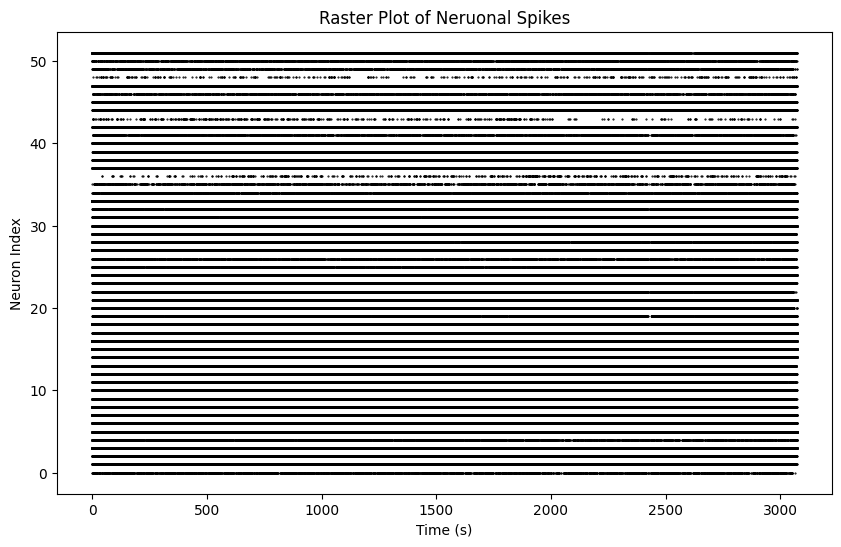

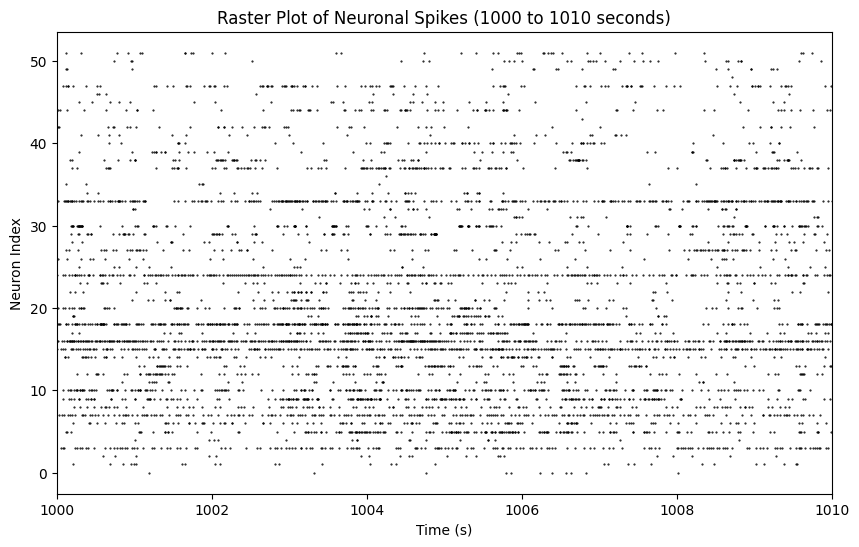

In [10]:
# Raster plot for the whole dataset:
plt.figure(figsize=(10, 6))

for i, neuron_spikes in enumerate(spike_times):
    plt.plot(neuron_spikes, [i] * len(neuron_spikes), 'k.', markersize=1)

plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Raster Plot of Neruonal Spikes')
plt.show()


# Raster plot for 1000s <= time <= 1010s:
plt.figure(figsize=(10, 6))

for i, neuron_spikes in enumerate(spike_times):
    neuron_spikes_1000to1010 = [spike for spike in neuron_spikes if 1000 <= spike <= 1010]
    plt.plot(neuron_spikes_1000to1010, [i] * len(neuron_spikes_1000to1010), 'k.', markersize=1)

plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Raster Plot of Neuronal Spikes (1000 to 1010 seconds)')
plt.xlim(1000, 1010)  # Set x-axis limits to the specified range
plt.show()

#### 1B.2. Plotting x- and y- components of velocity over time:

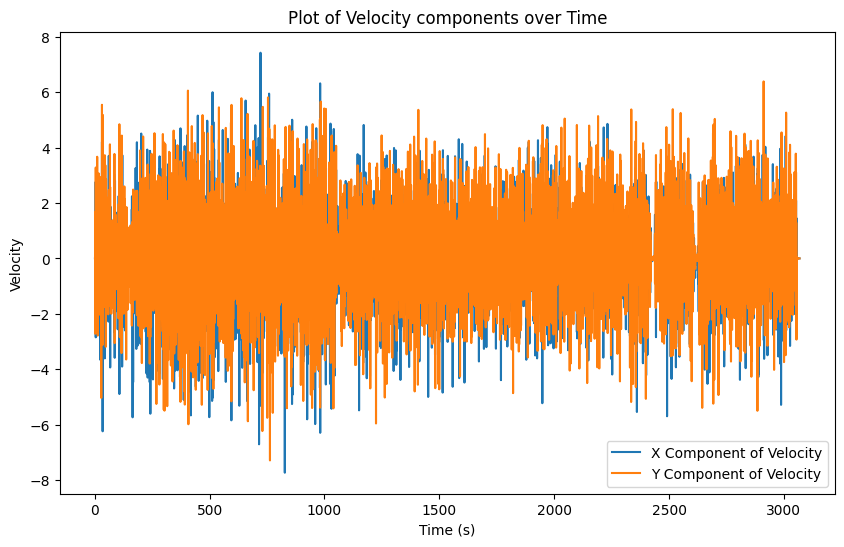

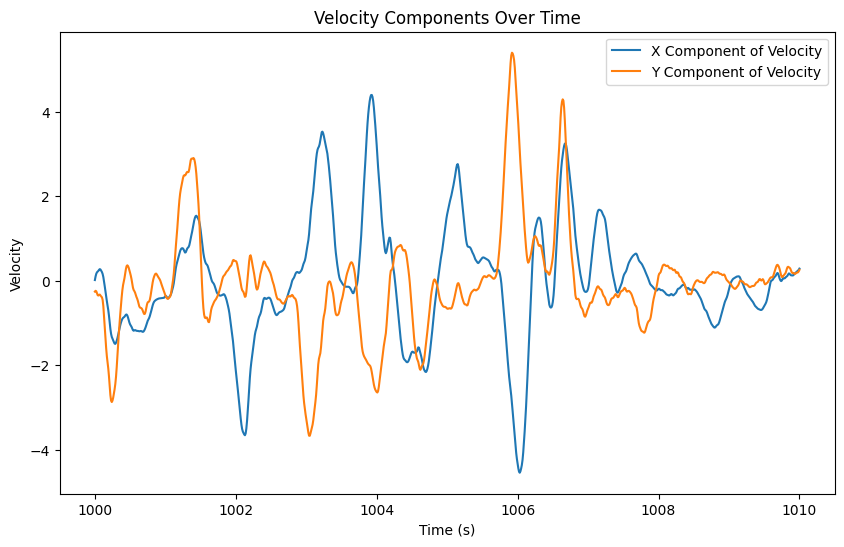

In [11]:
# Velocity-Time plot for the whole dataset:
plt.figure(figsize=(10, 6))

vel_x = [v[0] for v in whitened_vel]
vel_y = [v[1] for v in whitened_vel]

plt.plot(vel_times, vel_x, label='X Component of Velocity')
plt.plot(vel_times, vel_y, label='Y Component of Velocity')

plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.title('Plot of Velocity components over Time')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(10, 6))

vel_1000to1010 = [v for v, t in zip(whitened_vel, vel_times) if 1000 <= t <= 1010]
vel_times_1000to1010 = [t for t in vel_times if 1000 <= t <= 1010]

vel_x_1000to1010 = [v[0] for v in vel_1000to1010]
vel_y_1000to1010 = [v[1] for v in vel_1000to1010]

plt.plot(vel_times_1000to1010, vel_x_1000to1010, label='X Component of Velocity')
plt.plot(vel_times_1000to1010, vel_y_1000to1010, label='Y Component of Velocity')

plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.title('Velocity Components Over Time')
plt.legend(loc='best')
plt.show()

#### 1B.3. Histogram of mean firing rates:

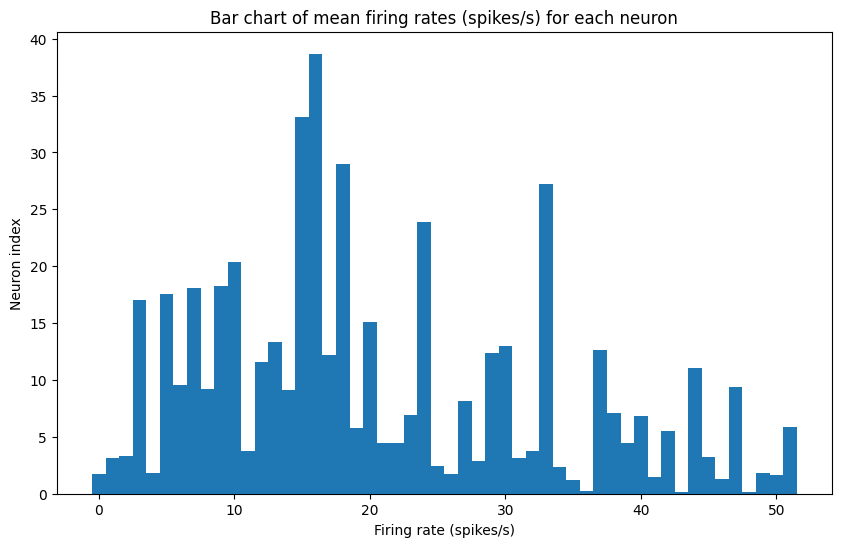

In [12]:
# Histogram of mean firing rates for each neuron:
plt.figure(figsize=(10, 6))
total_time = vel_times[-1] - vel_times[0]   # Total time of the experiment (in seconds)
mean_firing_rates = [len(neuron_spikes) / total_time for neuron_spikes in spike_times]  # For each neuron, mean firing rate (sp/s) = number of spikes recorded / total time of the experiment

plt.bar(range(len(spike_times)), mean_firing_rates, width=1)

plt.xlabel('Firing rate (spikes/s)')
plt.ylabel('Neuron index')
plt.title('Bar chart of mean firing rates (spikes/s) for each neuron')
plt.show()

#### 1B.4. Plot of velocity curve in (x,y) space:

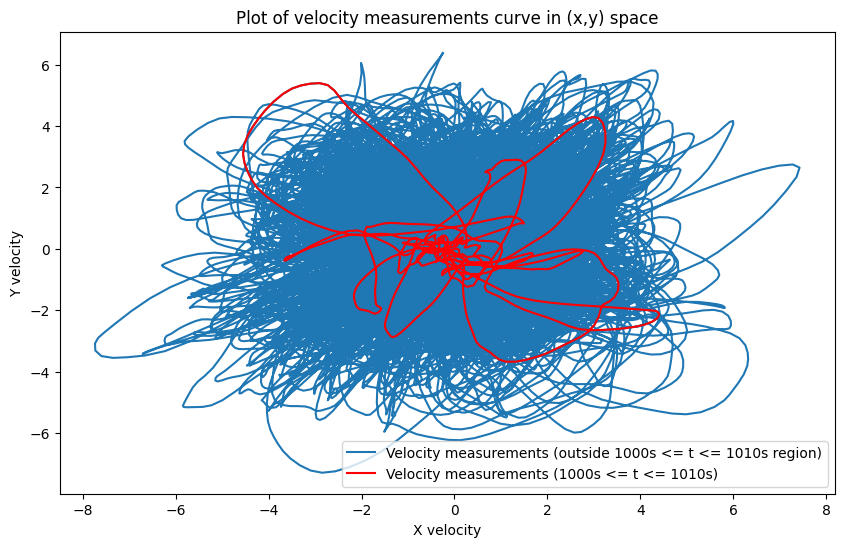

In [13]:
# Plot all velocities as points in (x, y)-plane as a continuous curve
# Emphasise the region from t=1000 to t=1010 with a different colour
plt.figure(figsize=(10, 6))

vel_x = [v[0] for v in whitened_vel]
vel_y = [v[1] for v in whitened_vel]

vel_x_1000to1010 = [v[0] for v, t in zip(whitened_vel, vel_times) if 1000 <= t <= 1010]
vel_y_1000to1010 = [v[1] for v, t in zip(whitened_vel, vel_times) if 1000 <= t <= 1010]

plt.plot(vel_x, vel_y, linestyle='-', label='Velocity measurements (outside 1000s <= t <= 1010s region)')
plt.plot(vel_x_1000to1010, vel_y_1000to1010, color='red', linestyle='-', label='Velocity measurements (1000s <= t <= 1010s)')

plt.xlabel('X velocity')
plt.ylabel('Y velocity')
plt.title('Plot of velocity measurements curve in (x,y) space')
plt.legend(loc='best')
plt.show()

------------------

## Task 2: Divide data into test/train and batches

1. As in any machine learning task, divide your data up into a non-overlapping training set, testing set and (optionally) validation set.
2. Write a generator function (see below) ``batched_data`` that iterates over your data in randomly ordered segments of a given length, returning it in batches. The function should have arguments that determine the range of data to use, the simulation time step that will be used, the length (in seconds) of each batch, and the batch size (you may add additional arguments if you wish). The function should return a pair of arrays ``(x, y)``. The array ``x`` has shape ``(batch_size, num_neurons, num_time_points)`` containing the spike times as an array where a zero indicates no spike and 1 indicates a spike. Here ``num_time_points`` is the number of time points in the batch measured at the sampling rate of the simulation time step, not the number of time points in the data as a whole, nor at the spike or velocity sampling rate. The array ``y`` has shape ``(batch_size, 2, num_time_points)`` containing the velocities at the same time points as the spikes. You will need to use some sort of interpolation to get the velocities at these times.
3. Plot a sample of spike times and velocities for a random batch of length 1 second and ``batch_size=4``.

**Note on generation functions**

Generator functions are an advanced feature of Python that makes it easy to iterate over complicated datasets. The general syntax is just a standard function that uses the keyword ``yield`` instead of ``return`` to return data, which allows it to return data multiple times. You can iterate over the values returned by a generator function instead of just calling it. Here's an example:

And another:

You can use the following template but you may want to define some additional helper functions to simplify your code and that you can re-use later.

#### **Preprocessing data:** Putting spikes and output in binned format

Spikes are recorded at a frequency of 30kHz, and due to this and the fact that we are working in 1ms timesteps, we decided to bin the spikes and velocities into 1ms bins.

In [14]:
######## BIN_SPIKES ########
def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    print("edges: " , edges.shape)
    # -1 is very important. It is because the bin goes between the times, not AT every time point, so there will be 1 one less
    # Note for vel, we want the spikes in between the 1e-3 gaps to account for the NEXT vel, not the previous one.
    # So to get the data for the first vel, we should go one timestep back in time for spikes.
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    print(num_neurons)
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    print("neural data: " , neural_data.shape)    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i]=np.histogram(spike_times[i],edges)[0]
    return neural_data

In [15]:
# Data Preprocessing Parameters
dt = 1e-3  # Size of time bins in seconds
t_start = vel_times[0]  # Start time for data extraction
t_end = vel_times[-1]  # End time for data extraction

# Preprocessing of Spike Times Data
# Removing extra dimension from spike_times array
spike_times = np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i] = np.squeeze(spike_times[i])

# Binning Neural Data
# The 'bin_spikes' function is used to bin the spike times data
neural_data = bin_spikes(spike_times, dt, t_start - dt, t_end)


# Create a new time split for interpolating velocities
start_time = vel_times[0]  # Start time of velocity recordings
end_time = vel_times[-1]  # End time of velocity recordings
new_times = np.arange(start_time, end_time, dt)  # New time split at 1ms intervals

# Velocity Data Interpolation
# Creating an interpolation function for velocities
interp_func = interp1d(vel_times, whitened_vel, axis=0, kind='cubic', fill_value="extrapolate")
new_vel = interp_func(new_times)  # Interpolating velocities on the new time grid

# The above code handles the preprocessing of neural and velocity data.
# It organizes spike times into a cleaner format, bins the neural data,
# and interpolates the velocity data over a new time grid.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


edges:  (3066991,)
52
neural data:  (3066990, 52)


#### Train-Validation-Test Split

In [16]:
# Splitting the dataset
# Assuming 'neural_data' and 'new_vel' are arrays with equal length
total_data_points = len(new_vel)

# Calculate the size of each set
train_size = int(total_data_points * 0.80)
val_size = int(total_data_points * 0.10)
test_size = total_data_points - train_size - val_size  # The rest for the test set

# Split the data
X_train = neural_data[:train_size]
y_train = new_vel[:train_size]
X_val = neural_data[train_size:train_size + val_size]
y_val = new_vel[train_size:train_size + val_size]
X_test = neural_data[train_size + val_size:]
y_test = new_vel[train_size + val_size:]

#### Batched data function

In [17]:
def batched_data(data, velocities, range_to_use=[0, 3066990], dt=1e-3, length=1, batch_size=64, num_neurons=52, max_num_batches=40):
    """
    Prepare batches of data for processing.

    Parameters:
    data (list): The dataset containing spike times.
    velocities (list): The dataset containing velocities.
    range_to_use (list): The range of indices to use from the dataset. Default is [0, 3066990].
    dt (float): Time step size. Default is 1e-3.
    length (int): Length of each time segment. Default is 1.
    batch_size (int): The size of each batch. Default is 64.
    num_neurons (int): The number of neurons in the dataset. Default is 52.
    max_num_batches (int): Maximum number of batches to process. Default is 40.

    Yields:
    Tensors: Batched spike time and velocity data as tensors.
    """

    # Calculate the number of time points in each batch
    num_time_points = int(length / dt)

    # Extract the specified range of data
    data = data[int(range_to_use[0]):int(range_to_use[1])]
    velocities = velocities[int(range_to_use[0]):int(range_to_use[1])]

    # Calculate the total number of data points
    total_data_points = len(data)

    # Calculate the number of batches and prepare indices for each batch
    num_batches = min(total_data_points // (batch_size * num_time_points), max_num_batches)
    batch_indices = [(i * batch_size * num_time_points, (i + 1) * batch_size * num_time_points) for i in range(num_batches)]

    # Shuffle batch indices for random batch selection
    random.shuffle(batch_indices)

    # Iterate over batches
    for start_idx, end_idx in batch_indices:
        # Initialize tensors for spike times (x) and velocities (y)
        x = torch.zeros((batch_size, num_neurons, num_time_points), device='cuda')
        y = torch.zeros((batch_size, 2, num_time_points), device='cuda')

        for b in range(batch_size):
            # Get spike times and velocities for the current batch
            spike_times = data[start_idx:start_idx + num_time_points]
            velocity_segment = velocities[start_idx:start_idx + num_time_points]

            # Convert data to tensors and assign to x and y
            x[b, :, :] = torch.tensor(spike_times).T
            y[b, :, :] = torch.tensor(velocity_segment).T

            # Update start index for the next segment within the batch
            start_idx += num_time_points

        yield x, y


#### Sample plots

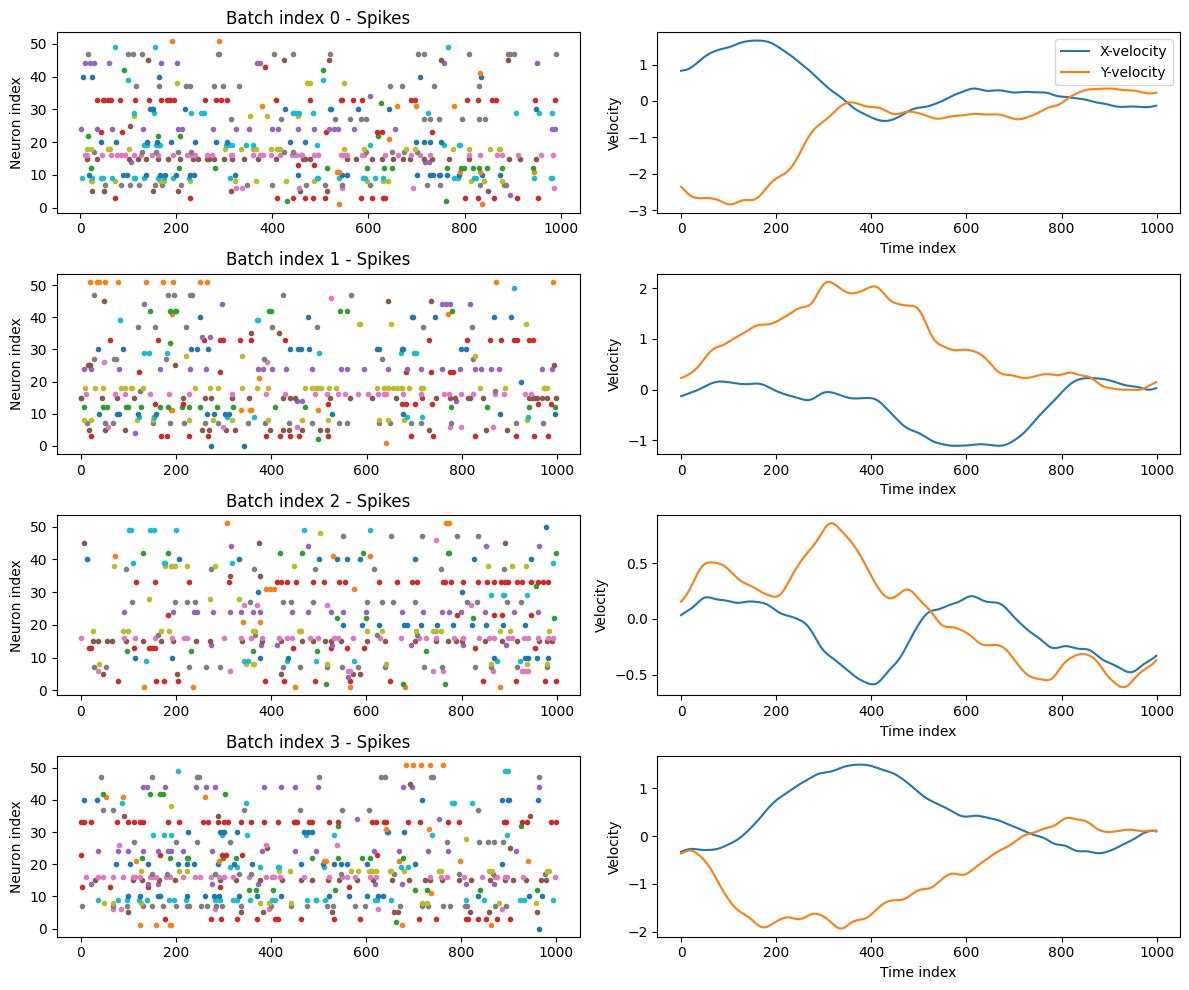

In [18]:
# Initialize the batch generator with the specified parameters
range_to_use = (0, 3066990)
batch_generator = batched_data(neural_data, new_vel, range_to_use=range_to_use, dt=0.001, batch_size=4)

# Retrieve a random batch of data
x, y = next(batch_generator)

# Set up the figure for plotting
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed

# Loop through each batch
for b in range(4):
    # Check if there are any spikes in the current batch
    if np.any(x[b].cpu().numpy() == 1):
        # Plot the spike trains for each neuron in the batch
        ax = plt.subplot(4, 2, 2*b+1)
        spike_train = x[b].cpu().numpy()
        for neuron_index in range(spike_train.shape[0]):
            # Find location of all spike times after theyve been batched (so to closest ms)
            spike_times = np.where(spike_train[neuron_index] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times) * neuron_index, marker='.')
        ax.set_ylabel('Neuron index')
        ax.set_title(f'Batch index {b} - Spikes')

        # Plot the X and Y velocities for the current batch
        ax2 = plt.subplot(4, 2, 2*b+2)
        ax2.plot(y[b][0].cpu().numpy(), label='X-velocity')
        ax2.plot(y[b][1].cpu().numpy(), label='Y-velocity')
        ax2.set_xlabel('Time index')
        ax2.set_ylabel('Velocity')
        # Add legend for the first batch for clarity
        if b == 0:
            ax2.legend(loc='best')

# Adjust layout for better visibility of plots
plt.tight_layout()
plt.show()


In [19]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

## Task 3: Simulation code

Write modular code to simulate a layer of leaky integrate-and-fire spiking neurons compatible with autodifferentiation with PyTorch. You can either write this as a function or class. The code should accept an input batch of spikes ``x`` of shape ``(batch_size, num_input_neurons, num_time_points)`` and values 0 or 1 (as in the ``batched_data`` generator function above). The code should have the option to produce either spiking or non-spiking output. In both cases, the output should be an array ``y`` of shape ``(batch_size, num_output_neurons, num_time_points)``. In the case of spiking output, the values of ``y`` should be 0s and 1s, and in the case of non-spiking output they should be the membrane potential values. You may also want to write an additional class to handle multiple layers of spiking neural networks for subsequent tasks.

Your code should include initialisation of the weight matrices, and add additional hyperparameters for this initialisation. You may also want to make the time constants of your neurons into hyperparameters. I used ``tau=50*ms`` for spiking neurons and ``tau=500*ms`` for non-spiking neurons and it worked OK, but I didn't do an extensive hyperparameter search.

I would recommend approaching this and the following sections as follows:

1. Write simulation code for a single layer, non-spiking neural network first. This code is simpler and will train fast (under 3 minutes on Colab). Attempt as much of the remaining tasks as possible using only this.
2. Add the ability for spiking and test that your code produces reasonable output but don't try to train it yet.
3. Add the ability to plot spiking hidden layers and try to get a reasonable initialisation of the network.
4. Start training the spiking neural network. Your final run will probably take a long time to train but you should build up to that by seeing how well the training curves improve for fewer epochs, batch sizes, etc.

You can use the template below if you want to use the class-based approach.

In [20]:
# LIFLayer: Class to simulate 1 layer of LIF neurons.
  # These neurons can be spiking or non-spiking (controlled by 'spiking' argument) and returns the appropriate output
    # spiking output: spikes in 0s and 1s
    # non-spiking output: membrane potential values

class LIFLayer(nn.Module):
  def __init__(self
               , n_in                   # Number of input neurons
               , n_out                  # Number of output neurons

               , spiking=False          # Whether the LIF Layer's neurons are spiking or non-spiking

               , tau=[0.5]              # (Hyperparameter) Time constant of neurons.
               , init_weight_scale=0.2  # (Hyperparameter) Additional hyperparameter for the intialisation of the weight matrices

               , dt=1e-3                # Time step
               ):

    super(LIFLayer, self).__init__()    # To inherit from the nn.Module base class
    self.n_in = n_in
    self.n_out = n_out
    self.spiking = spiking
    self.tau = tau
    self.init_weight_scale = init_weight_scale
    self.dt = dt

    self.alpha = np.exp(-self.dt/self.tau)  # (As in the lectures) Alpha will be used in the model to calculate membrane potential
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ## Store weights as a trainable parameter

    # Baseline weight initialisation:
    # self.w = nn.Parameter(torch.randn(n_in, n_out) * self.init_weight_scale) # Initialisation of the weight matrices

    # After experimenting with different initialisation methods and tuning the init_weight_scale hyperparameter, we found that the minimal MSE (while adhering to the desired firing rate range)
    # was using He (Normal) Initialisation with init_weight_scale = 0.2
    w = torch.empty(n_in, n_out).to(self.device)
    nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')
    self.w = nn.Parameter(w * init_weight_scale)


  def forward(self, x): # input x = "a batch of spikes"
    batch_size, num_input_neurons, num_time_points = x.shape

    # Membrane potential:
    v_mem = torch.zeros(batch_size, self.n_out, device=self.device)

    # Outputs:
      # y: if the layer is non-spiking
      # spikes_out: if the layer is spiking

      # Here, we initialise both possible output arrays' shapes
    y = torch.zeros(batch_size, self.n_out, num_time_points, device=self.device)
    spikes_out = torch.zeros(batch_size, self.n_out, num_time_points, device=self.device)

    # Perform the calculations for membrane potential (according to the theory in lectures)
    for t in range(num_time_points):

      V_thresh = v_mem - 1  # Threshold voltage
      out = surrogate_heaviside(V_thresh)
      reset = out.detach()

      h = torch.matmul(x[:, :, t], self.w)

      new_mem = (v_mem * self.alpha + h) * (1.0 - reset)

      # Update the output arrays appropriately (spiking or non-spiking)
      y[:, :, t] = v_mem
      spikes_out[:, :, t] = out

      v_mem = new_mem # Pass the calculated membrane potential to the next layer's calculation (feed forward)


    # Return the appropriate output array:
    if not self.spiking:
      return y
    else:
      return spikes_out

# MultiLayerSNN: Class to implement multiple LIF Layers
class MultiLayerSNN(nn.Module):
  def __init__(self
               , layer_sizes
               , spiking=[True, False]
               , tau=[0.1]
               , init_weight_scale=1.0
               , plot=[True, False]        # Plot setting: Whether to plot the spike activity (Raster plot and Firing rates histogram) for each layer
               ):

    super(MultiLayerSNN, self).__init__()  # To inherit from the nn.Module base class

    self.plot = plot
    self.spiking = spiking

    # Initialising each layer with the LIFLayer class
    self.layers = nn.ModuleList()
    for i in range(len(layer_sizes) - 1):
      self.layers.append(
          LIFLayer(layer_sizes[i], layer_sizes[i+1], spiking[i], tau[i], init_weight_scale)
      )

  def forward(self, x):
    idx=0 # This counter variable is used to keep track of the settings (spiking and plot) of each layer

    # Pass each input through a layer (LIFLayer)
    for layer in self.layers:
      x = layer(x)

      # Plot Raster plot of spikes if plot setting is True for this layer:
      if self.plot[idx]:
        b = 0
        spike_train = x[b].detach().cpu().numpy()

        plt.figure(figsize=(15, 8))

        for neuron_index in range(spike_train.shape[0]):
            spike_times = np.where(spike_train[neuron_index] == 1)[0]
            plt.scatter(spike_times, np.ones_like(spike_times) * neuron_index, marker='.', s=1)

        plt.xlabel('Time')
        plt.ylabel('Neuron index')
        plt.title(f'Hidden Spikes')
        plt.show()

        # Plot Histogram of Firing Rates if the layer is also spiking:
        if self.spiking[idx]:

            total_time = x[b].size(1) / 1000

            mean_firing_rates = [torch.sum(neuron_spikes == 1).item() / total_time for neuron_spikes in x[b].cpu()]

            plt.figure(figsize=(10, 4))
            plt.hist(mean_firing_rates, bins=20)
            plt.title("Histogram of spiking hidden layer")
            plt.xlabel("Firing Rate")
            plt.ylabel("Count")
            plt.show()

      idx+=1
    return x

## Task 4: Evaluation functions

Write code that takes a network and testing range as input and returns the mean loss over the testing data. The loss is the mean squared error of the output of the network compared to the target data. You may also find it helpful to compute the null loss, which is the loss you would get if you just output all zeros. You should be able to do better than this!

Also write code that plots some of the internal outputs of the network, for example to show you the spikes produced by hidden layers, calculate their firing rates, etc.

Initialise a network with one hidden layer of 100 spiking neurons and one output layer of 2 non-spiking neurons. Run this on a random sample of the data of length 1 and plot the input spikes, hidden layer spikes, output x- and y-velocities, and the data x- and y-velocities. For each spiking layer compute the firing rates of each neuron and plot them as a histogram.

You can use this to initialise your networks in a reasonable state. Hidden layers should fire spikes at rates that are not too low and not too high. I aimed for an average firing rate in the range 20-100 and it worked well, but you can experiment with other options. The output layer should give values that are roughly in the right range as the data (i.e. it shouldn't go to +/- 100 if the data is going to only +/- 4). If you look at the spike trains of your hidden layer and all the neurons at initialisation are doing exactly the same thing then it's probably not going to learn very well, so try out some different weight initialisations to see if you can do better.

Print the value of the loss (and optionally the null loss) for your untrained network, to give you an idea of the baseline.

You may want to wrap your evaluation code in a ``with`` statement like below to stop PyTorch from computing gradients when evaluating (unnecessary and expensive):

```python
with torch.no_grad():
    ...
    # whatever you do here won't compute any gradients
```

In [22]:
### Function to calculate the MSE of the network's output over a testing range.

'''
• Here, the testing range is a subset of the test data.

• The MSE is calculated by batch and the mean MSE by batch is calculated to be the MSE for the netork.
  There are different approaches to calculate the MSE of the network when taking batches into consideration,
  but we found this to be the most intuitive way, as well as the approach taken in other existing ML libraries (e.g., tf.keras.losses)

• This function also returns the null loss, which is the MSE of the network if the outputs were all zeros.
  This is to be used as benchmark throughout this coursework.
'''

def evaluate_network(network, inputs, targets, batch_size, range_to_use):

    # Keep track of the total MSE loss across all batches:
    total_loss = 0.0
    null_loss = 0.0

    # Keep track of the number of batches for which the MSE is being calculated:
    number_of_batches = 0

    with torch.no_grad(): # torch.no_grad() is used to prevent PyTorch from computing gradients during the MSE calculation since it is unnecessary and computationally expensive in this case.

        # Batch the given test data. Here, inputs_batched will represent inputs to the network and targets_batched will represent ground truth values for velocities.
        for inputs_batched, targets_batched in batched_data(inputs, targets,range_to_use=range_to_use, dt= 0.001, batch_size=batch_size):

            outputs = network(inputs_batched)     # Pass the inputs through the network to get predictions for velocities.

            loss = mse(outputs, targets_batched)  # Calculate loss (MSE) between predictions and ground truth
            total_loss += loss.item()             # Accumulate loss (MSE)
            null_loss += mse(torch.zeros_like(outputs), targets_batched).item() # Calculate and accumulate the null loss (MSE)

            number_of_batches +=1                 # Increment the number of batches for which the MSE has been calculated

    # Calculate the mean MSE losses:
    mean_loss = total_loss / number_of_batches
    mean_null_loss = null_loss / number_of_batches

    return mean_loss, mean_null_loss

In [23]:
### Function to plot a Raster plot of neuronal spikes at the input (of the network):

def plot_input_spikes(x): # x = input spikes

    b = 0                             # Batch index, we are only concerned with looking at 1 batch in order to visualise the Raster plot of input spikes.
    spike_train = x[b].cpu().numpy()  # Getting 1 batch of input spikes.

    # Plot Raster plot for spikes:
    plt.figure(figsize=(15, 8))

    for neuron_index in range(spike_train.shape[0]):
        spike_times = np.where(spike_train[neuron_index] == 1)[0]
        plt.scatter(spike_times, np.ones_like(spike_times) * neuron_index, marker='.', s=1)

    plt.xlabel('Time')
    plt.ylabel('Neuron index')
    plt.title(f'Input Spikes')
    plt.show()

#### FOR HIDDEN LAYER PLOTS:

**This is done in Task 3's class, as part of the function itself, based on whether 'plots' is True or False**

In [24]:
### Function to plot a histogram of the mean firing rates of neurons in a layer:

def plot_histogram(spikes, title="Firing Rates"):

    total_time = spikes.size(1) / 1000  # Total time of the experiment (in seconds)

    # Calculate mean firing rates for each neuron:
    mean_firing_rates = [torch.sum(neuron_spikes == 1).item() / total_time for neuron_spikes in spikes]

    # Plot mean firing rates as a histogram:
    plt.figure(figsize=(10, 4))
    plt.hist(mean_firing_rates, bins=20)
    plt.title("Histogram of firing rates input layer")
    plt.xlabel("Firing Rate")
    plt.ylabel("Count")
    plt.show()

In [25]:
### Function to plot the output velocities (predictions) of the network:

def plot_output_vels(y, Title):  # y = output velocities

    b = 0                                     # Batch index, we are only concerned with looking at 1 batch in order to plot velocity.
    output_vels = y[b].detach().cpu().numpy() # Getting 1 batch of velocity data.

    plt.figure(figsize=(15, 8))

    # Plot the x- and y- components of velocity separately
    plt.plot(output_vels[0], label='X-velocity')
    plt.plot(output_vels[1], label='Y-velocity')

    plt.title(Title)
    plt.xlabel('Time index')
    plt.ylabel('Velocity')
    plt.legend()
    plt.show()

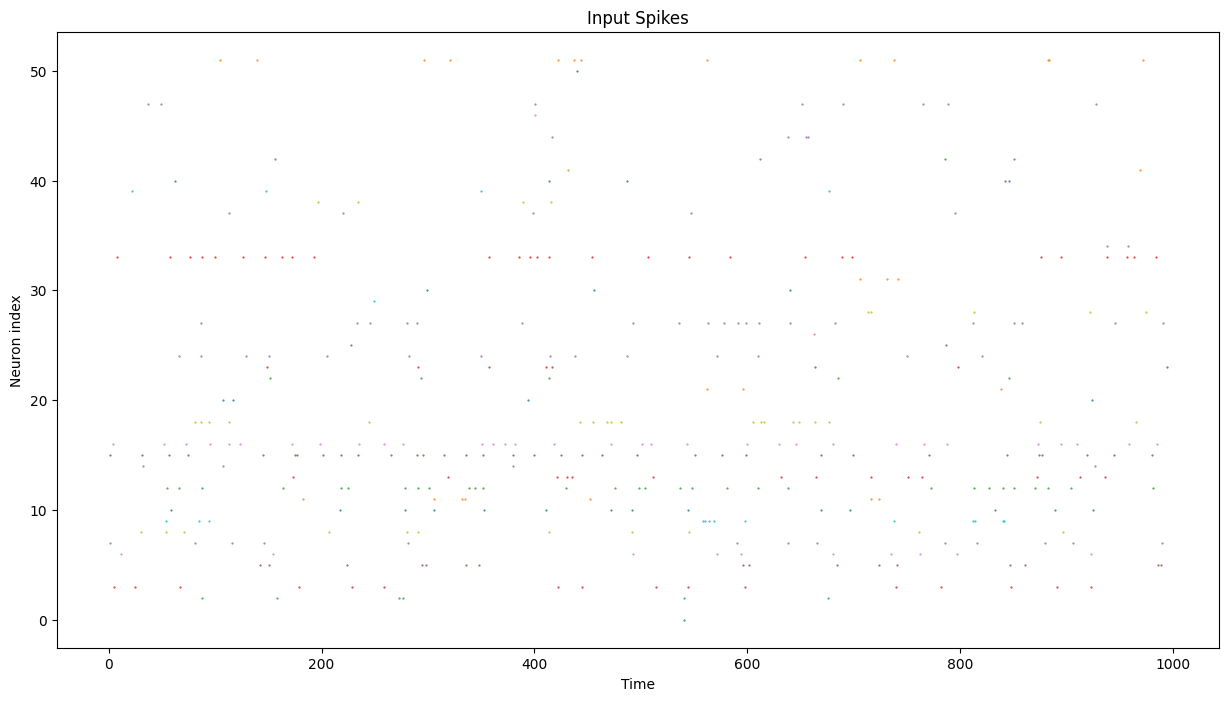

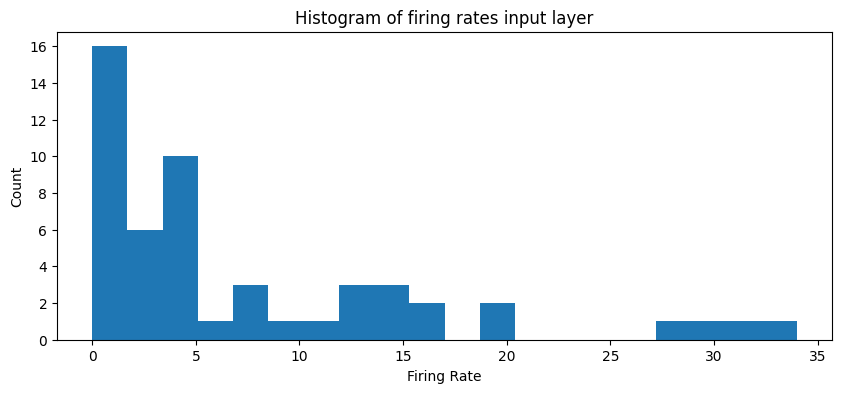

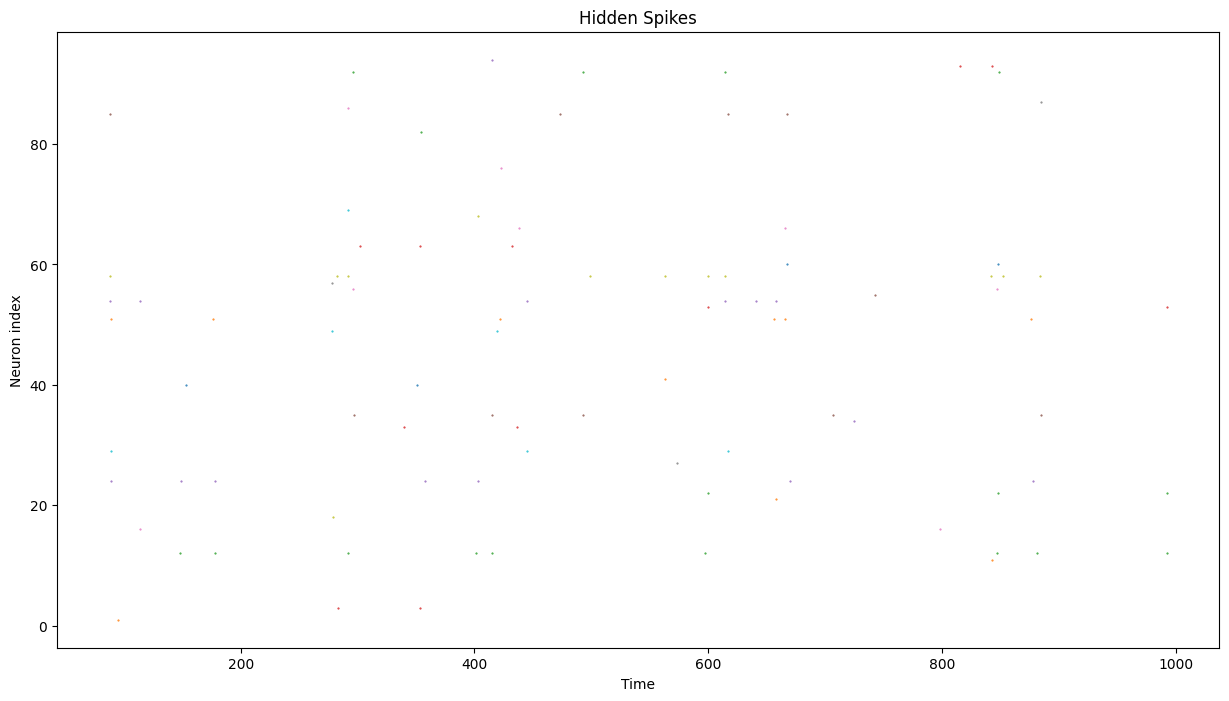

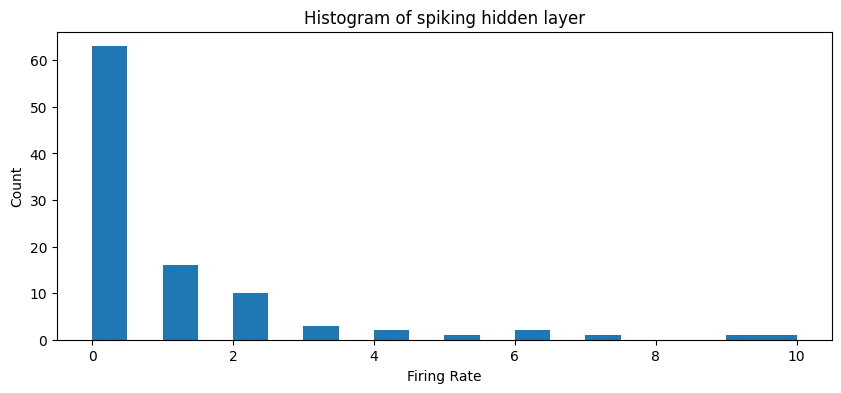

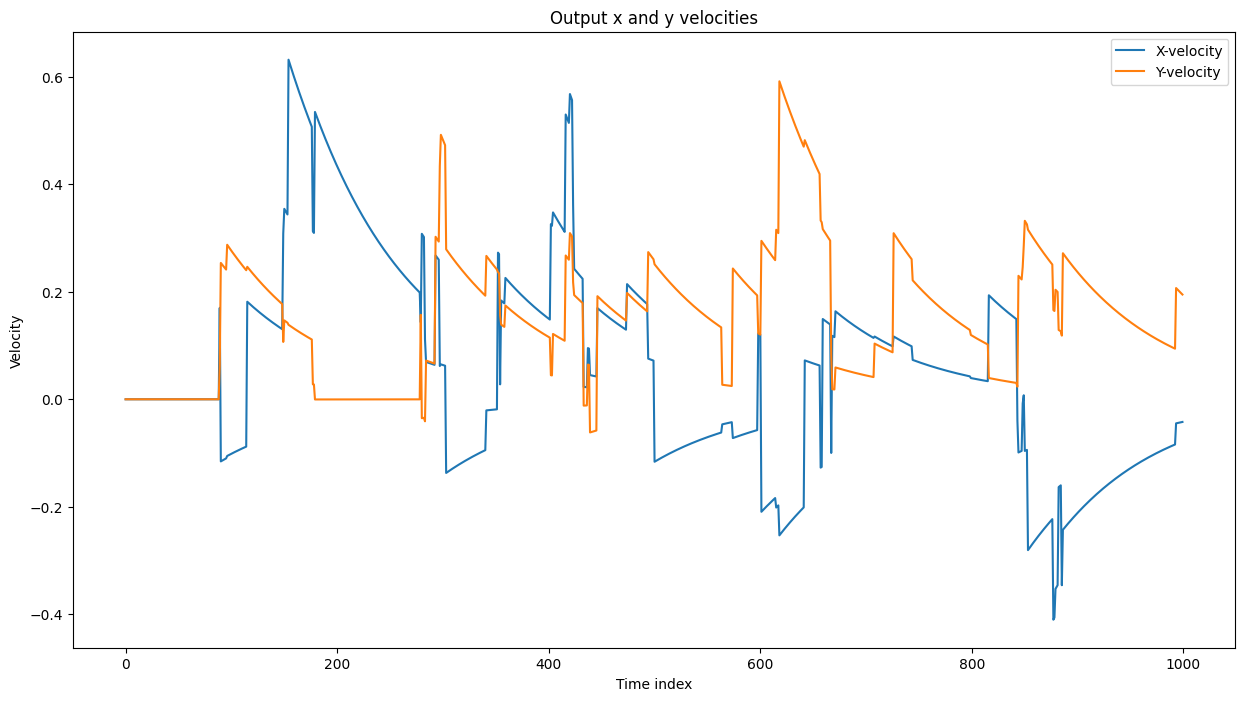

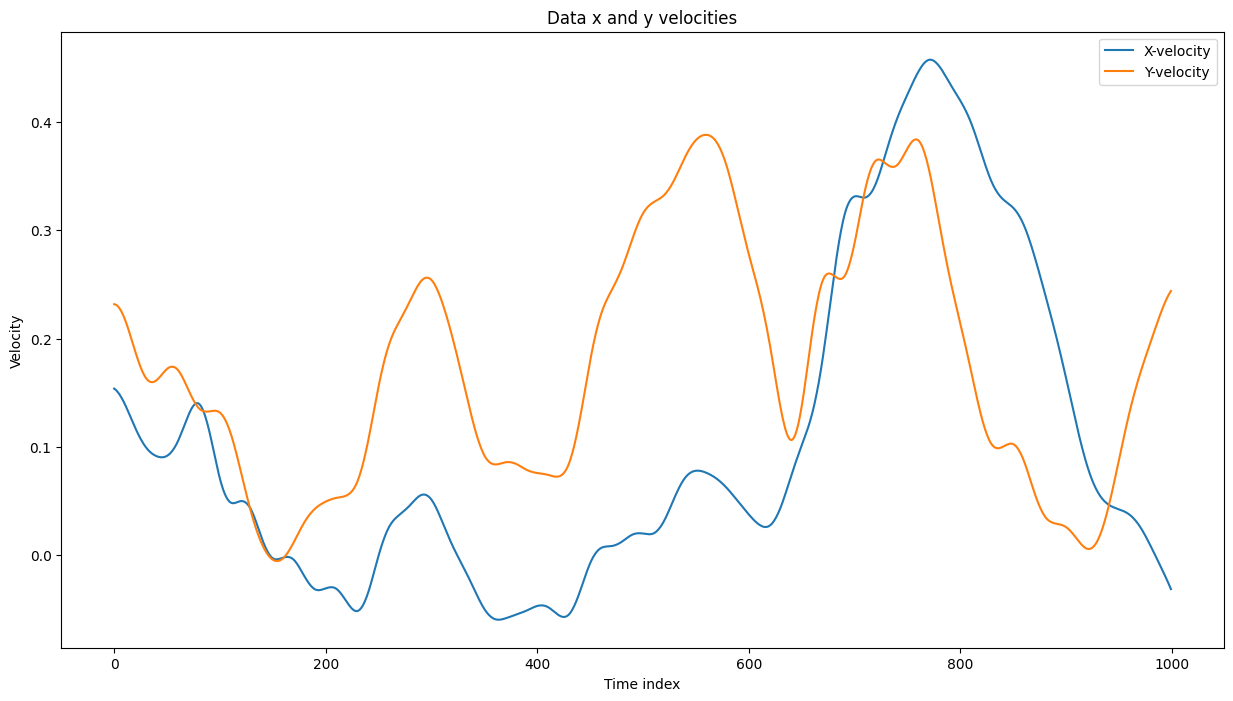

Mean Loss (MSE):  0.9100701411565145  Mean Null Loss (MSE):  0.7341466347376505


In [28]:
# Network Configuration
layers = [52, 100, 2]  # Structure of the network (number of neurons per layer)
init_weight_scale = 1  # Initial weight scale for the network
tau_spiking = 0.01  # Initialise membrane time constant for spiking neurons
tau_nonspiking = 0.1    # Initialise membrane time constant for non-spiking neurons
# Network Initialization
network = MultiLayerSNN(layers, spiking=[True, False], tau=[tau_spiking, tau_nonspiking], init_weight_scale=init_weight_scale, plot=[True, False]).to(device)

# Simulation Parameters
length = 1  # Duration of the input signal
dt = 0.001  # Time step for the simulation
num_time_steps = int(length / dt)  # Number of time steps in the simulation
range_to_use = [100000, 150000]  # Range of data to use for training

# Data Preparation
batch_generator = batched_data(X_train, y_train, range_to_use, dt=dt, batch_size=8, max_num_batches=5)  # Generator for batched data
input_data, ground_truth = next(batch_generator)  # Fetch the first batch of data

# Visualization of Input Data
plot_input_spikes(input_data)  # Plot input spikes
plot_histogram(input_data[0])  # Plot histogram of the first batch of input data

# Processing with the Network
output_of_network = network(input_data)  # Get network output for the input data

# Visualization of Network Output
plot_output_vels(output_of_network, "Output x and y velocities")  # Plot output velocities from the network
plot_output_vels(ground_truth, "Data x and y velocities")  # Plot ground truth velocities for comparison

# Evaluation
network.plot = [False, False]  # Disable plotting inside the network
mean_loss, mean_null_loss = evaluate_network(network, X_val, y_val, batch_size=8, range_to_use=range_to_use)  # Evaluate the network

# Print Evaluation Results
print("Mean Loss (MSE): ", mean_loss, " Mean Null Loss (MSE): ", mean_null_loss)  # Print the mean loss and the mean null loss


### **Finding the best initialiser and tuning initialiser hyperparameter:**

![Initialiser hyperparameter tuning experiment (Snippet)](initialiserhyperparametertuningexperiment.png)

The plot above shows an example of the results achieved with our optimisation experiments for finding the best initialiser and tuning the init_weight_scale hyperparameter, by testing the average MSE of the 1-layer network over multiple runs. In this case, the measurements were averaged over 3 runs.

It is important to note that, while different values of init_weight_scale with different initialisers achieved lower MSEs, some initialisers (such as Orthogonal) did not achieve other desired criteria such as firing rate of neurons, etc.

## Task 5: Training

Start with a single non-spiking output layer (i.e. spikes connected directly via a weight matrix to two non-spiking LIF neurons as output). Find a good initialisation for this network that gives outputs roughly in the right range.

Select an optimisation algorithm, learning rate, etc. and train your network.

Has your algorithm converged?

You should be able to do better than the null loss (but you don't need to do hugely better). I get a null loss of around 0.8 and a trained loss of around 0.6.

At the end of training, plot your loss curves for training and test/validation data and print out your testing loss. Plot the output of your model and compare to the target data for 8 randomly sampled time windows of length 1. You may notice that your network matches the data better in the second half of the window than the first half, because the network always starts at a value zero even if the data doesn't. We'll look into this more in the next task. Don't worry too much if the fits don't look great at this stage. If you get a mean squared error of around .75 of the null MSE then you're doing fine.

You may want to use the following code as a starting point (it worked well enough for me but you can probably do better). On my desktop with CPU only, this took about two minutes to train.

100%|██████████| 600/600 [05:34<00:00,  1.80it/s, epoch=9, last_epoch_loss=0.629, val_loss=0.494]


testing_loss=0.568054735660553, null_testing_loss=0.9647561311721802


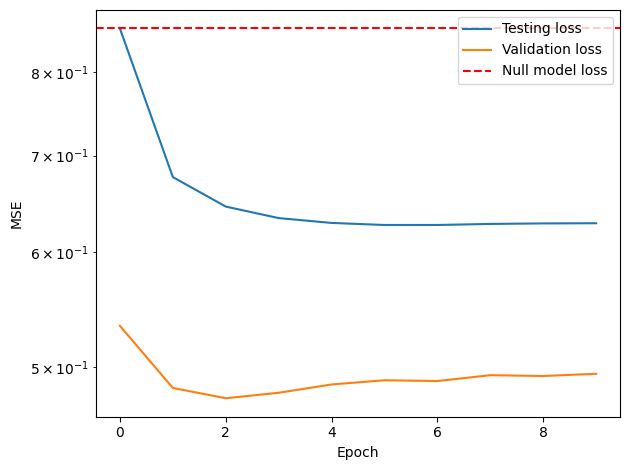

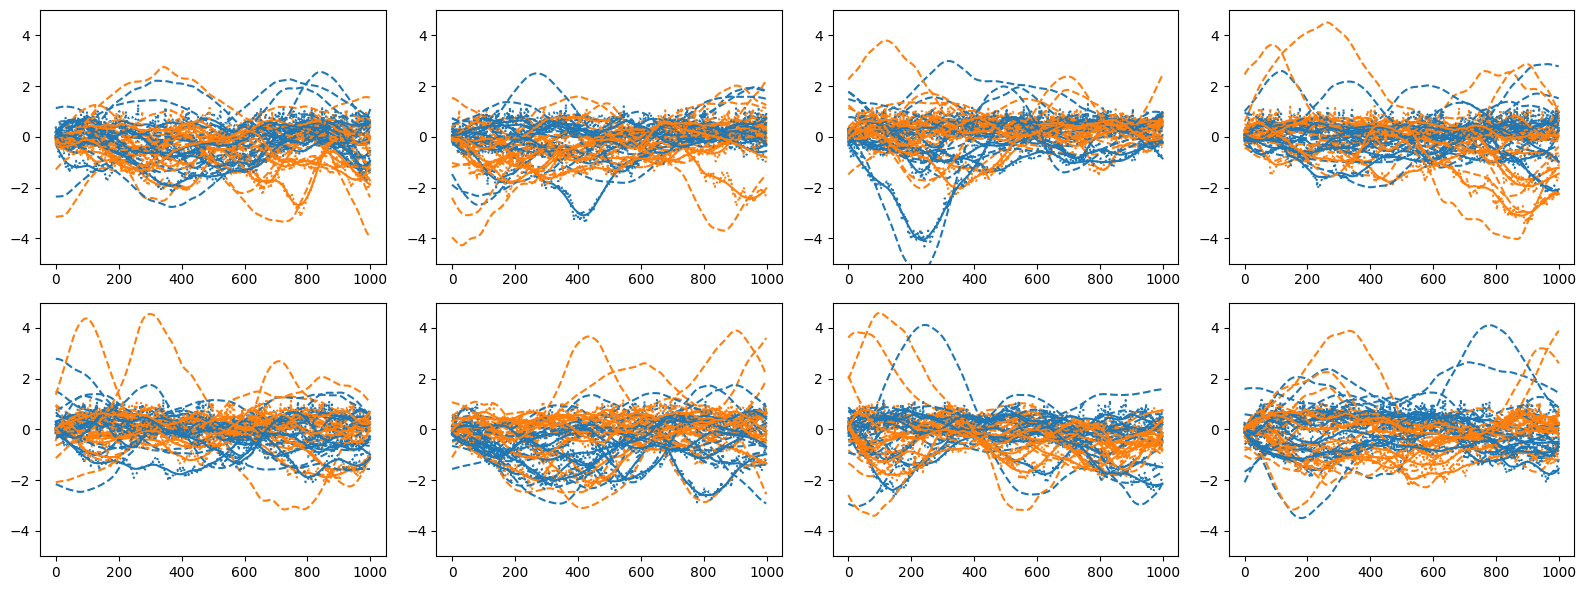

In [42]:
# Network and Training Parameters
tau = [0.1]  # Time constant for the Spiking Neural Network (SNN)
init_weight_scale = 0  # Initial weight scale for the network
layers = [52, 2]  # Structure of the network (number of neurons per layer)

length = 1  # Duration of the input signal
dt = 0.001  # Time step for the simulation
num_time_steps = int(length / dt)  # Number of time steps in the simulation
range_to_use = (0, 3066990)  # Range of data to use for training

# Training hyperparameters
lr = 0.001  # Learning rate
num_epochs = 10  # Number of epochs for training
max_num_batches = 60  # Maximum number of batches per epoch
batch_size = 32  # Batch size for training

# Network Initialization
net = MultiLayerSNN(layers, spiking=[False], tau=tau, init_weight_scale=init_weight_scale, plot=[False]).to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)  # Optimizer for training

# Training Loop
loss_hist = []  # List to store training loss history
val_loss_hist = []  # List to store validation loss history
with tqdm(total=num_epochs * max_num_batches) as pbar:  # Progress bar for training
    last_epoch_loss = val_loss = null_val_loss = None
    for epoch in range(num_epochs):
        local_loss = []  # List to store loss for each batch
        for x, y in batched_data(X_train, y_train, range_to_use, dt=dt, batch_size=batch_size, max_num_batches=max_num_batches):
            y_out = net(x)  # Run the network with batched input
            loss = mse(y_out, y)  # Compute Mean Squared Error (MSE) loss
            local_loss.append(loss.item())

            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate error
            optimizer.step()  # Update weights

            pbar.update(1)  # Update progress bar
            pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)


        last_epoch_loss = np.mean(local_loss)  # Average loss for the epoch
        loss_hist.append(last_epoch_loss)  # Append loss to history
        val_loss, null_val_loss = evaluate_network(net, X_val, y_val, batch_size=batch_size, range_to_use=range_to_use)
        val_loss_hist.append(val_loss)  # Append validation loss to history
        pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, val_loss=val_loss)

# Evaluation and Plotting
testing_loss, null_testing_loss = evaluate_network(net, X_test, y_test, batch_size=batch_size, range_to_use=range_to_use)
print(f'{testing_loss=}, {null_testing_loss=}')

# Plotting training and validation loss over epochs
plt.semilogy(loss_hist, label='Testing loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plotting trained output
plt.figure(figsize=(16, 6))
with torch.no_grad():
    for x, y in batched_data(X_test, y_test, range_to_use=range_to_use, batch_size=batch_size, max_num_batches=max_num_batches):
        for b in range(8):
            plt.subplot(2, 4, b+1)
            y_out = net(x)
            # Plot outputs and true values
            plt.plot(y_out[b, 0, :].cpu(), ':C0', label='x_out')
            plt.plot(y_out[b, 1, :].cpu(), ':C1', label='y_out')
            plt.plot(y[b, 0, :].cpu(), '--C0', label='x')
            plt.plot(y[b, 1, :].cpu(), '--C1', label='y')
            # Plot a smoothed version
            plt.plot(savgol_filter(y_out[b, 0, :].cpu(), 151, 3), '-C0', label='x_out (smooth)')
            plt.plot(savgol_filter(y_out[b, 1, :].cpu(), 151, 3), '-C1', label='y_out (smooth)')
            plt.ylim(-5, 5)
plt.tight_layout()


**As we can see, the algorithm has converged, so our training was successful**

#### Parameter used and optimised for:

In [43]:
from torch.optim import AdamW, SGD, RMSprop
param_grid = {
    'tau': [0.05, 0.1, 0.15],
    'init_weight_scale': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0],
    'lr': [0.001, 0.005, 0.01],
    'num_epochs': [10, 15, 20, 30],
    'max_num_batches': [40, 50, 60, 67],
    'batch_size': [32],
    'optimizer': [AdamW, SGD, RMSprop]
}

In [44]:
network_for_6 = net

## Task 6: Longer length decoding

Your code above probably doesn't look great when plotted. That's partly because the outputs start at 0 but the data doesn't necessarily have to, so it takes a while for them to get in sync, and partly because on some intervals it will just do badly. To fix this, and to extend the fit to a longer range of data, in this task we only use the final timestep of each segment and compare to the data. Take a 15 second segment of testing data, and sample every 0.2 seconds to get 75 data points. For each data point, take a 1 second segment of time before this data point (these will be overlapping), run your simulation for that one second, and use the final time point of the simulated output as your prediction. Plot this compared to the real data for 8 different segments of 15 seconds.

This should look like a reasonable fit to the data. Congratulations, you have used raw spiking output of neurons recorded from a monkey's brain to predict what it was doing on a computer screen it was interacting with. That's a brain machine interface right here.

You can use the template below to get you started.

Your results might look something like this:

![Fits](fits.png)

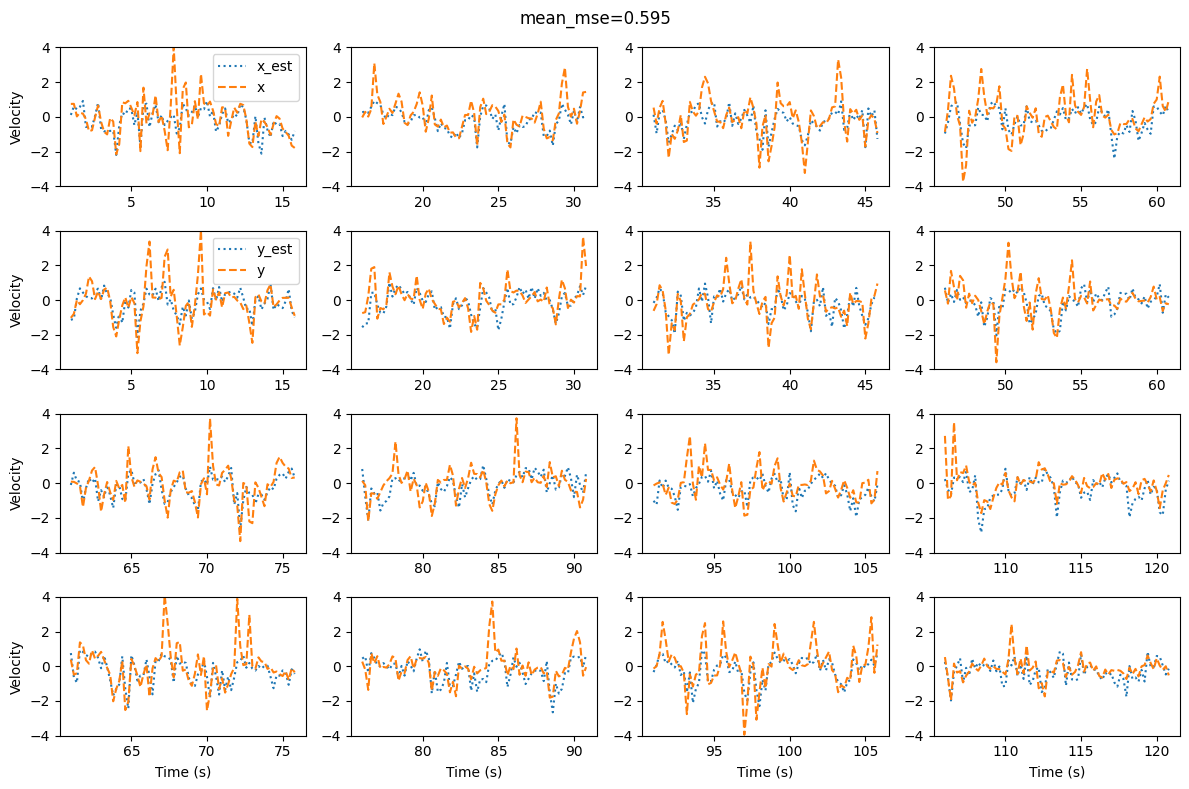

In [46]:
def decoding_plot(decoding_range, X_input, y_input, network, num_neurons, dt_decoding=0.2, decoding_length=15, length=1, dt=1e-3, figdims=(4, 2)):
    # Collect timesteps at which to sample in seconds
    w_intervals = np.arange(decoding_range[0]+length, decoding_range[0]+length+decoding_length, dt_decoding)
    batch_size_single = len(w_intervals) ## removed -1 here
    num_time_points = int(np.round(length/dt))
    nfx, nfy = figdims
    nf = nfx*nfy
    batch_size = nf*batch_size_single
    nrows = nfy*2
    ncols = nfx
    with torch.no_grad():
        x = torch.zeros((batch_size, num_neurons, num_time_points),device=device)
        y = torch.zeros((batch_size, 2, num_time_points),device=device)
        T = []

        for b in range(batch_size):
          # The start of the one second interval before the point of interest
          w_start = int((decoding_range[0] + dt_decoding * b) / dt)
          w_end = int(w_start + length / dt)
          # Copy data to x and y tensors
          x[b, :, :] = torch.tensor(X_input[:, w_start:w_end], dtype=torch.float32)
          y[b, :, :] = torch.tensor(y_input[:, w_start:w_end], dtype=torch.float32)


        # Run the selected input through the network to get predicted velocities
        y_out = network(x)

        # Find mse between y and y_out to get loss
        mean_mse = mse(y, y_out)


        # Calculate the number of points in each segment
        points_per_segment = int(decoding_length / dt_decoding)

        # Find the values of the final velocities in each 1 second batch (this is what were trying to predict and compare)
        y_final = y[:, :, -1]
        y_out_final = y_out[:, :, -1]

        plt.figure(figsize=(ncols*3, nrows*2))
        # Iterate over the number of plots (nf) which should be equal to total_segments
        for nf_i in range(nf):
            sp_x = nf_i % nfx
            sp_y = nf_i // nfx

            # Calculate the starting and ending time for each segment
            segment_start_time = nf_i * decoding_length + length
            segment_end_time = segment_start_time + decoding_length - dt_decoding

            # Create a time vector for the current segment
            # Essentially same as w_intervals, but increases starting time with each batch to match data
            current_time_vector = np.linspace(segment_start_time, segment_end_time, points_per_segment)


            for i in range(2):
                plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y+i*ncols)

                # For each of x and y velocities of y_out_final and y_final, extract the 75 datapoints that will constitute each 15 second batch
                y_out_slice = y_out_final[nf_i * batch_size_single:(nf_i+1) * batch_size_single, i].detach().cpu().numpy()
                y_slice = y_final[nf_i * batch_size_single:(nf_i+1) * batch_size_single, i].detach().cpu().numpy()

                # Plot predicted velocities against actual velocities
                plt.plot(current_time_vector, y_out_slice, ':', label=f'{["x", "y"][i]}_est')   ## Blue
                plt.plot(current_time_vector, y_slice, '--', label=f'{["x", "y"][i]}')          ## Orange

                plt.ylim(-4, 4)
                if sp_x==0:
                    plt.ylabel('Velocity')
                if 2*sp_y+i==nrows-1:
                    plt.xlabel('Time (s)')
                if nf_i == 0:
                    plt.legend(loc='best')

        plt.suptitle(f'{mean_mse=:.3f}')
        plt.tight_layout()


decoding_range = [0, 3066990]


decoding_plot(decoding_range=decoding_range, X_input=X_test.T, y_input=y_test.T, num_neurons=52, network=network_for_6)

## Task 7: Comparing spiking and non-spiking

Now try training your network with at least one spiking hidden layer. Compare your results to the non-spiking version. Note that training times with a spiking hidden layer are likely to be much longer. My training time went up from 2 minutes to 30 minutes (with CPU only).

With the spiking layer do you do worse, as well, or better? (There is no correct answer here, but if you can do much better let me know we might be able to write a paper on this.)

#### There are three versions below:

1. Simple: with layers [52, 100, 2] where we have a spiking input, a spiking hidden layer and a non-spiking output.

2. Multiple hidden spiking: with layers [52, 300, 20, 2] where we have a spiking input, 2 spiking hidden layers and a non-spiking output.

3. Mix of hidden layers: with layers [52, 300, 20, 2] where we have a spiking input, a spiking hidden layer a non-spiking hidden layer and a non-spiking output.

Analysis: Addition of spiking hidden layer increases runtime significantly, but seems to have little effect on the minimum value loss that can be achieved.  
Simple seems to preform best, but this may be because it is least computationally expensive compared to the other two.  
With enough training, simple can reach and slightly beat the non spiking version.
The other versions require a lot more training (emphasis on a lot) to reach decent loss values.  
I believe the last one is the most promising, with more training it would preform much better.  

RECOMMENDED: Use T4 GPU on Google Colab to run

1. Simple

100%|██████████| 400/400 [11:32<00:00,  1.73s/it, epoch=9, last_epoch_loss=0.723, val_loss=0.527]


testing_loss=0.6227647297912173, null_testing_loss=0.9647561311721802


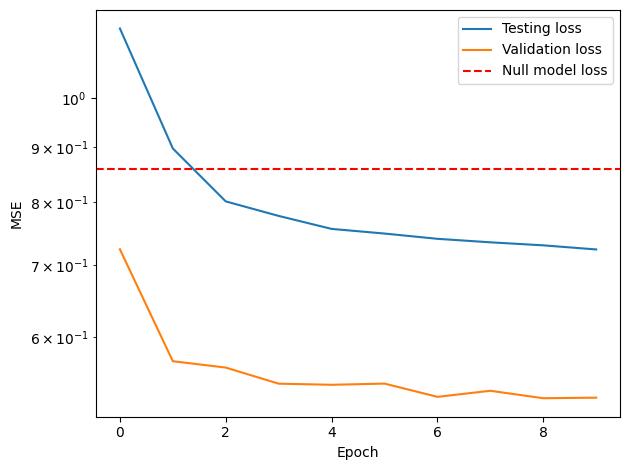

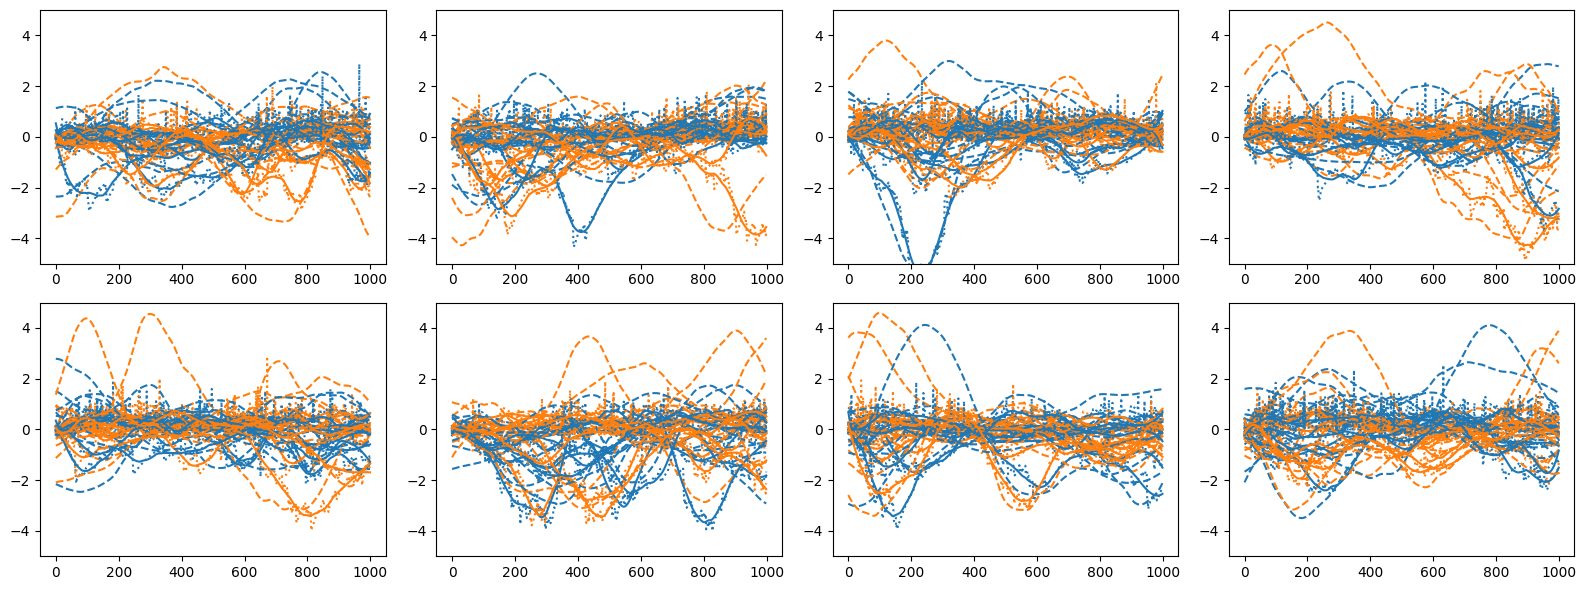

In [57]:
# Network and Training Parameters
tau_spiking = 0.01 # Membrane time constant for spiking neurons
tau_nonspiking= 0.1 # Membrane time constant for non-spiking neurons
init_weight_scale = 0.8 # Initial weight scale for the network
layers = [52, 100, 2] # Structure of the network (number of neurons per layer)
length = 1  # Duration of the input signal
dt = 0.001  # Time step for the simulation
num_time_steps = int(length / dt)  # Number of time steps in the simulation
range_to_use = (0, 3066990)  # Range of data to use for training

# Training hyperparameters
lr = 0.001  # Learning rate
num_epochs = 10  # Number of epochs for training
max_num_batches = 40  # Maximum number of batches per epoch
batch_size = 32  # Batch size for training

# Network Initialization
net = MultiLayerSNN(layers, spiking= [True, False], tau=[tau_spiking, tau_nonspiking], init_weight_scale=init_weight_scale, plot=[False, False]).to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)  # Optimizer for training

# Training Loop
loss_hist = []  # List to store training loss history
val_loss_hist = []  # List to store validation loss history
with tqdm(total=num_epochs * max_num_batches) as pbar:  # Progress bar for training
    last_epoch_loss = val_loss = null_val_loss = None
    for epoch in range(num_epochs):
        local_loss = []  # List to store loss for each batch
        for x, y in batched_data(X_train, y_train, range_to_use, dt=dt, batch_size=batch_size, max_num_batches=max_num_batches):
            y_out = net(x)  # Run the network with batched input
            loss = mse(y_out, y)  # Compute Mean Squared Error (MSE) loss
            local_loss.append(loss.item())

            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate error
            optimizer.step()  # Update weights

            pbar.update(1)  # Update progress bar
            pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)


        last_epoch_loss = np.mean(local_loss)  # Average loss for the epoch
        loss_hist.append(last_epoch_loss)  # Append loss to history
        val_loss, null_val_loss = evaluate_network(net, X_val, y_val, batch_size=batch_size, range_to_use=range_to_use)
        val_loss_hist.append(val_loss)  # Append validation loss to history
        pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, val_loss=val_loss)

# Evaluation and Plotting
testing_loss, null_testing_loss = evaluate_network(net, X_test, y_test, batch_size=batch_size, range_to_use=range_to_use)
print(f'{testing_loss=}, {null_testing_loss=}')

# Plotting training and validation loss over epochs
plt.semilogy(loss_hist, label='Testing loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plotting trained output
plt.figure(figsize=(16, 6))
with torch.no_grad():
    for x, y in batched_data(X_test, y_test, range_to_use=range_to_use, batch_size=batch_size, max_num_batches=max_num_batches):
        for b in range(8):
            plt.subplot(2, 4, b+1)
            y_out = net(x)
            # Plot outputs and true values
            plt.plot(y_out[b, 0, :].cpu(), ':C0', label='x_out')
            plt.plot(y_out[b, 1, :].cpu(), ':C1', label='y_out')
            plt.plot(y[b, 0, :].cpu(), '--C0', label='x')
            plt.plot(y[b, 1, :].cpu(), '--C1', label='y')
            # Plot a smoothed version
            plt.plot(savgol_filter(y_out[b, 0, :].cpu(), 151, 3), '-C0', label='x_out (smooth)')
            plt.plot(savgol_filter(y_out[b, 1, :].cpu(), 151, 3), '-C1', label='y_out (smooth)')
            plt.ylim(-5, 5)
plt.tight_layout()


In [58]:
network_for_7_1 = net

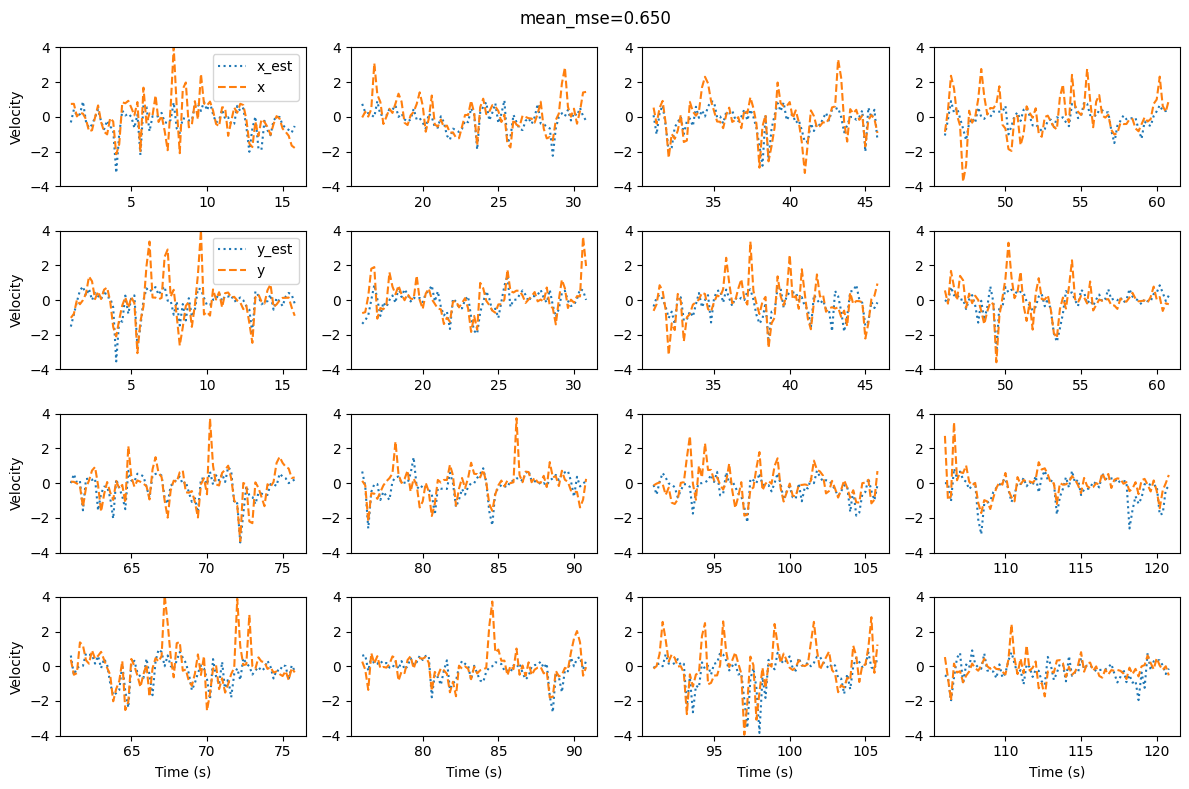

In [59]:
decoding_plot(decoding_range=decoding_range, X_input=X_test.T, y_input=y_test.T, num_neurons=52, network=network_for_7_1)

2. Multiple hidden spiking

100%|██████████| 800/800 [49:37<00:00,  3.72s/it, epoch=19, last_epoch_loss=0.71, val_loss=0.545]


testing_loss=0.6437057058016459, null_testing_loss=0.9647561311721802


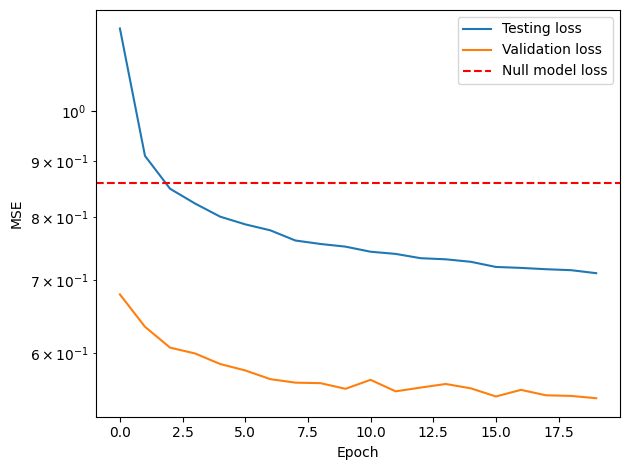

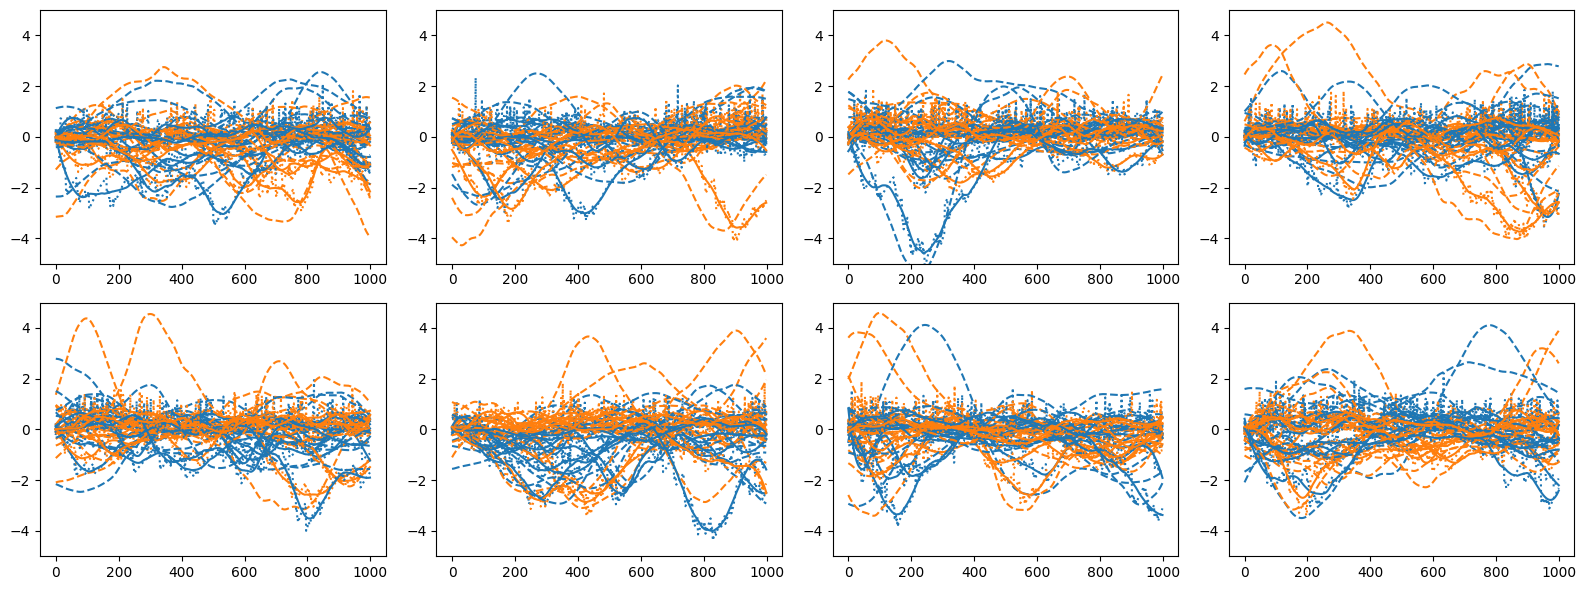

In [52]:
# Network and Training Parameters
tau_spiking = 0.01 # Membrane time constant for spiking neurons
tau_nonspiking= 0.1 # Membrane time constant for non-spiking neurons
init_weight_scale_n = 1.4 # Initial weight scale for the network
layers = [52, 300, 20, 2] # Structure of the network (number of neurons per layer)
length = 1  # Duration of the input signal
dt = 0.001  # Time step for the simulation
num_time_steps = int(length / dt)  # Number of time steps in the simulation
range_to_use = (0, 3066990)  # Range of data to use for training

# Training hyperparameters
lr = 0.001  # Learning rate
num_epochs = 20  # Number of epochs for training
max_num_batches = 40  # Maximum number of batches per epoch
batch_size = 32  # Batch size for training

# Network Initialization
net = MultiLayerSNN(layers, spiking= [True, True, False], tau=[tau_spiking, tau_spiking, tau_nonspiking], init_weight_scale=init_weight_scale_n, plot=[False, False, False]).to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)  # Optimizer for training

# Training Loop
loss_hist = []  # List to store training loss history
val_loss_hist = []  # List to store validation loss history
with tqdm(total=num_epochs * max_num_batches) as pbar:  # Progress bar for training
    last_epoch_loss = val_loss = null_val_loss = None
    for epoch in range(num_epochs):
        local_loss = []  # List to store loss for each batch
        for x, y in batched_data(X_train, y_train, range_to_use, dt=dt, batch_size=batch_size, max_num_batches=max_num_batches):
            y_out = net(x)  # Run the network with batched input
            loss = mse(y_out, y)  # Compute Mean Squared Error (MSE) loss
            local_loss.append(loss.item())

            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate error
            optimizer.step()  # Update weights

            pbar.update(1)  # Update progress bar
            pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)


        last_epoch_loss = np.mean(local_loss)  # Average loss for the epoch
        loss_hist.append(last_epoch_loss)  # Append loss to history
        val_loss, null_val_loss = evaluate_network(net, X_val, y_val, batch_size=batch_size, range_to_use=range_to_use)
        val_loss_hist.append(val_loss)  # Append validation loss to history
        pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, val_loss=val_loss)

# Evaluation and Plotting
testing_loss, null_testing_loss = evaluate_network(net, X_test, y_test, batch_size=batch_size, range_to_use=range_to_use)
print(f'{testing_loss=}, {null_testing_loss=}')

# Plotting training and validation loss over epochs
plt.semilogy(loss_hist, label='Testing loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plotting trained output
plt.figure(figsize=(16, 6))
with torch.no_grad():
    for x, y in batched_data(X_test, y_test, range_to_use=range_to_use, batch_size=batch_size, max_num_batches=max_num_batches):
        for b in range(8):
            plt.subplot(2, 4, b+1)
            y_out = net(x)
            # Plot outputs and true values
            plt.plot(y_out[b, 0, :].cpu(), ':C0', label='x_out')
            plt.plot(y_out[b, 1, :].cpu(), ':C1', label='y_out')
            plt.plot(y[b, 0, :].cpu(), '--C0', label='x')
            plt.plot(y[b, 1, :].cpu(), '--C1', label='y')
            # Plot a smoothed version
            plt.plot(savgol_filter(y_out[b, 0, :].cpu(), 151, 3), '-C0', label='x_out (smooth)')
            plt.plot(savgol_filter(y_out[b, 1, :].cpu(), 151, 3), '-C1', label='y_out (smooth)')
            plt.ylim(-5, 5)
plt.tight_layout()


In [54]:
network_for_7_2 = net

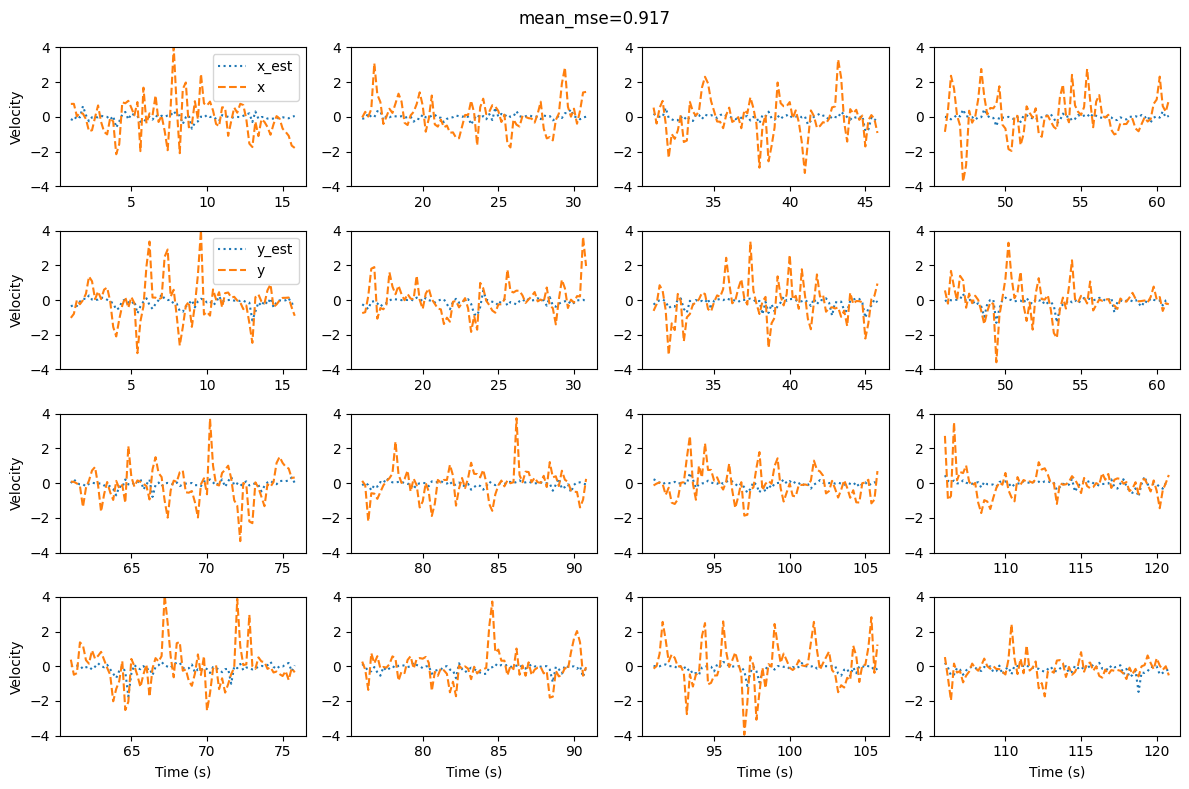

In [63]:
decoding_plot(decoding_range=decoding_range, X_input=X_test.T, y_input=y_test.T, num_neurons=52, network=network_for_7_2)

3. Mix of hidden layers

100%|██████████| 300/300 [19:02<00:00,  3.81s/it, epoch=9, last_epoch_loss=0.85, val_loss=0.589]


testing_loss=0.6896757351027595, null_testing_loss=0.9647561311721802


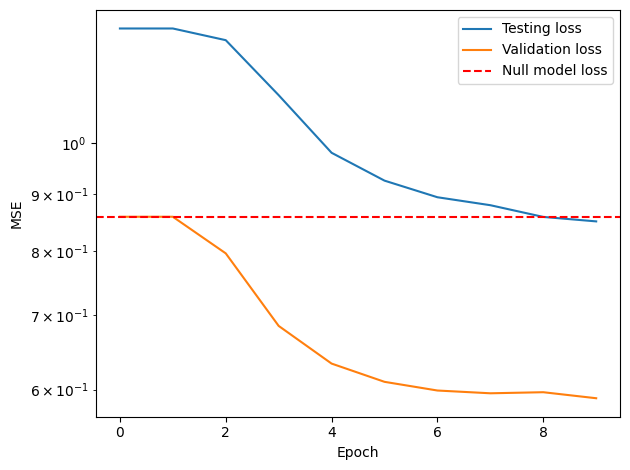

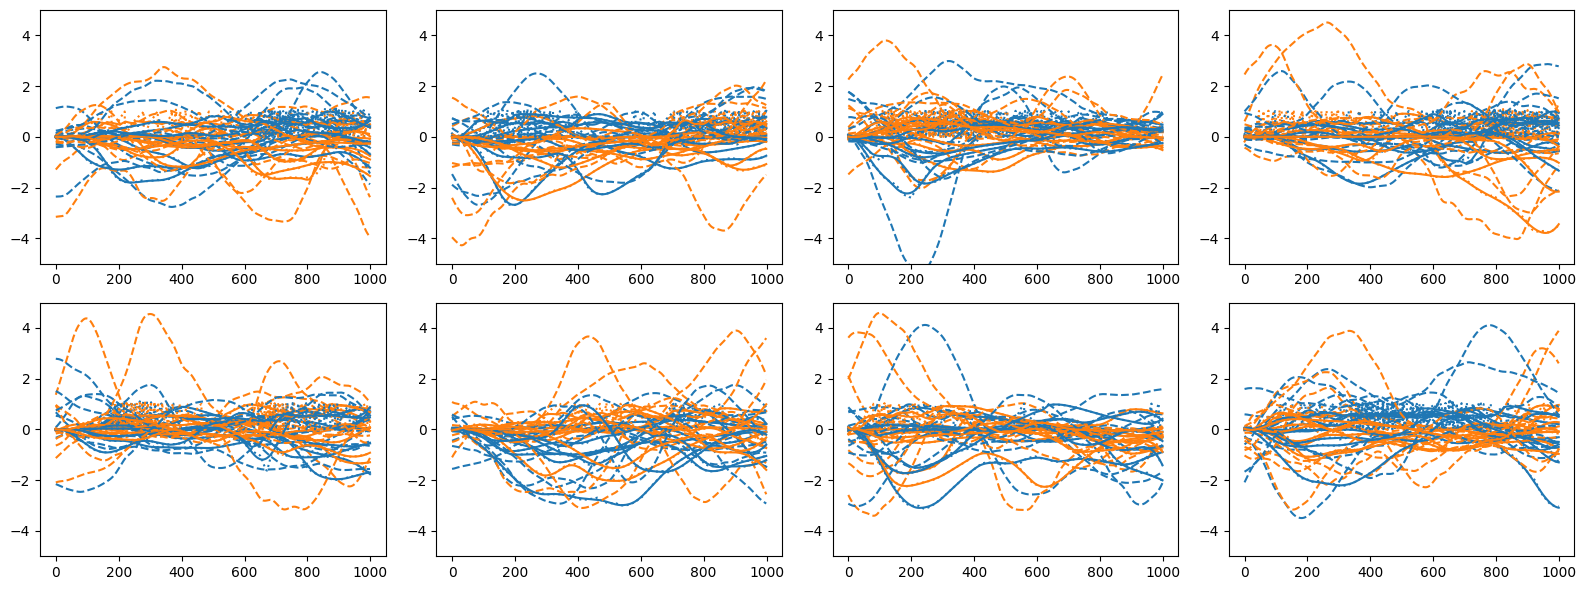

In [61]:
# Network and Training Parameters
tau_spiking = 0.01 # Membrane time constant for spiking neurons
tau_nonspiking= 0.1 # Membrane time constant for non-spiking neurons
init_weight_scale_m = 0.1 # Initial weight scale for the network
layers = [52, 300, 20, 2] # Structure of the network (number of neurons per layer)
length = 1  # Duration of the input signal
dt = 0.001  # Time step for the simulation
num_time_steps = int(length / dt)  # Number of time steps in the simulation
range_to_use = (0, 3066990)  # Range of data to use for training

# Training hyperparameters
lr = 0.001  # Learning rate
num_epochs = 10  # Number of epochs for training
max_num_batches = 30  # Maximum number of batches per epoch
batch_size = 32  # Batch size for training

# Network Initialization
net = MultiLayerSNN(layers, spiking= [True, False, False], tau=[tau_spiking, tau_nonspiking, tau_nonspiking], init_weight_scale=init_weight_scale_m, plot=[False, False, False]).to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)  # Optimizer for training

# Training Loop
loss_hist = []  # List to store training loss history
val_loss_hist = []  # List to store validation loss history
with tqdm(total=num_epochs * max_num_batches) as pbar:  # Progress bar for training
    last_epoch_loss = val_loss = null_val_loss = None
    for epoch in range(num_epochs):
        local_loss = []  # List to store loss for each batch
        for x, y in batched_data(X_train, y_train, range_to_use, dt=dt, batch_size=batch_size, max_num_batches=max_num_batches):
            y_out = net(x)  # Run the network with batched input
            loss = mse(y_out, y)  # Compute Mean Squared Error (MSE) loss
            local_loss.append(loss.item())

            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate error
            optimizer.step()  # Update weights

            pbar.update(1)  # Update progress bar
            pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)


        last_epoch_loss = np.mean(local_loss)  # Average loss for the epoch
        loss_hist.append(last_epoch_loss)  # Append loss to history
        val_loss, null_val_loss = evaluate_network(net, X_val, y_val, batch_size=batch_size, range_to_use=range_to_use)
        val_loss_hist.append(val_loss)  # Append validation loss to history
        pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, val_loss=val_loss)

# Evaluation and Plotting
testing_loss, null_testing_loss = evaluate_network(net, X_test, y_test, batch_size=batch_size, range_to_use=range_to_use)
print(f'{testing_loss=}, {null_testing_loss=}')

# Plotting training and validation loss over epochs
plt.semilogy(loss_hist, label='Testing loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plotting trained output
plt.figure(figsize=(16, 6))
with torch.no_grad():
    for x, y in batched_data(X_test, y_test, range_to_use=range_to_use, batch_size=batch_size, max_num_batches=max_num_batches):
        for b in range(8):
            plt.subplot(2, 4, b+1)
            y_out = net(x)
            # Plot outputs and true values
            plt.plot(y_out[b, 0, :].cpu(), ':C0', label='x_out')
            plt.plot(y_out[b, 1, :].cpu(), ':C1', label='y_out')
            plt.plot(y[b, 0, :].cpu(), '--C0', label='x')
            plt.plot(y[b, 1, :].cpu(), '--C1', label='y')
            # Plot a smoothed version
            plt.plot(savgol_filter(y_out[b, 0, :].cpu(), 151, 3), '-C0', label='x_out (smooth)')
            plt.plot(savgol_filter(y_out[b, 1, :].cpu(), 151, 3), '-C1', label='y_out (smooth)')
            plt.ylim(-5, 5)
plt.tight_layout()


In [62]:
network_for_7_3 = net

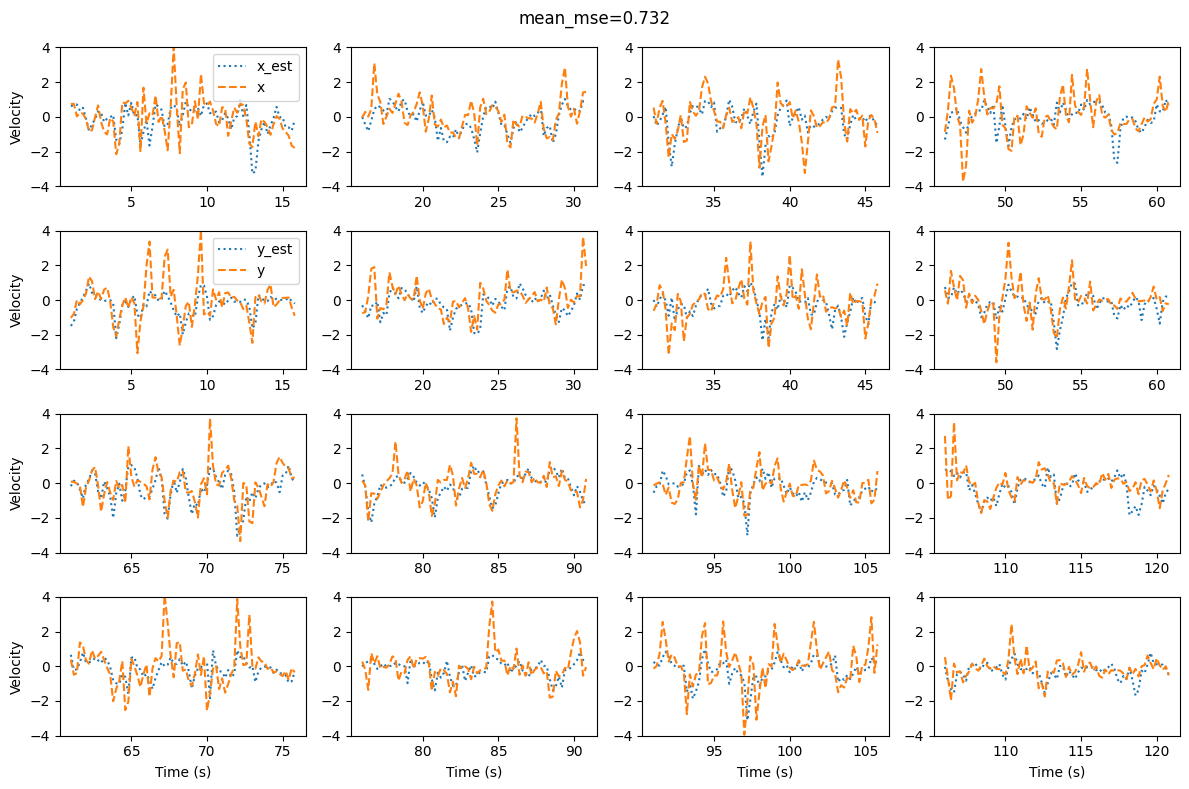

In [64]:
decoding_plot(decoding_range=decoding_range, X_input=X_test.T, y_input=y_test.T, num_neurons=52, network=network_for_7_3)